In [4]:
# imports
import sys; sys.path.insert(0, '..')

import os
import glob
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from scipy.special import comb

import trajectory_reconstruction_tradeoff as T
import random
import scanpy as sc
import altair as alt
from altair_saver import save
from sklearn import linear_model
import warnings

warnings.filterwarnings('ignore')

random.seed(20)

In [5]:
# params
dirname = '/cs/labs/mornitzan/nomoriel/trajectory_reconstruction_tradeoff/'
datadir = os.path.join(dirname, 'datasets' )
outdir = os.path.join(dirname, 'output_new2')


colors_prosstt = {
    'linear_rep0': 'navy', 
    # 'bifur_at_1': 'blue', 
    # 'bifur_at_2': 'deepskyblue',#'cyan', 
    # 'bifur_at_3': 'aquamarine', 
    # 'bifur_at_1_to_3': 'lightsalmon', 
    # 'bifur_at_2_to_3': 'tomato', 
    # 'bifur_at_1_to_4': 'red', 
    }

colors_real = {  
    'hayashi': 'seagreen',
    'dendritic': 'mediumseagreen',
    # 'hepatoblast': 'plum',
    'fibroblasts': 'orchid', 
    'hematopoiesis': 'mediumorchid',
    }

colors = {**colors_prosstt, **colors_real}

def is_prosstt(dataset):
    return dataset in colors_prosstt.keys()

datasets = colors.keys() # ['linear', 'bifur_at_1_to_4', 'hayashi', 'hepatoblast']# 
# remove hepato and all prosstt but linear

## Datasets (FigS1)

In [6]:
# read datasets
trajs = {}
for dataset in datasets:
    X, _, meta = T.io.read_dataset(dataset=dataset, dirname=datadir)
    trajs[dataset] = T.tr.Trajectory(X, meta=meta)

ntrajs = len(trajs)

In [7]:
# preliminaries

# plotting configs - two row location
two_loc = {}
for icolor_dict, color_dict in enumerate([colors_prosstt, colors_real]):
    for itraj, (traj_desc, _) in enumerate(color_dict.items()):
        two_loc[traj_desc] = (icolor_dict, itraj)
         
two_ncols =  max( len(colors_prosstt), len(colors_real) )

two_row_config = {'nrows': 2, 'ncols': two_ncols, 'figsize': (6*two_ncols, 6 * 2), 'constrained_layout':True, 'tight_layout':False}
one_row_config = {'nrows': 1, 'ncols': ntrajs, 'figsize': (6*ntrajs, 6), 'constrained_layout':True, 'tight_layout':False}
one_loc = { traj_desc: itraj for itraj,traj_desc in enumerate(datasets) }

# plotting configs - one row location
plot_config = one_row_config
plot_loc = one_loc


# generate palettes
palettes = {}
for itraj, (traj_desc, traj) in enumerate(trajs.items()):
    color = 'branch' if is_prosstt(traj_desc) else 'milestone_id'
    unique = traj.meta[color].unique()
    palette = dict(zip(unique, sns.color_palette(n_colors=len(unique))))
    palettes[traj_desc] = palette

# fixing datanames
traj_fignames = {k:k for k,v in trajs.items()}
traj_fignames['hayashi'] = 'mESC'
traj_fignames['linear_rep0'] = 'simulated'

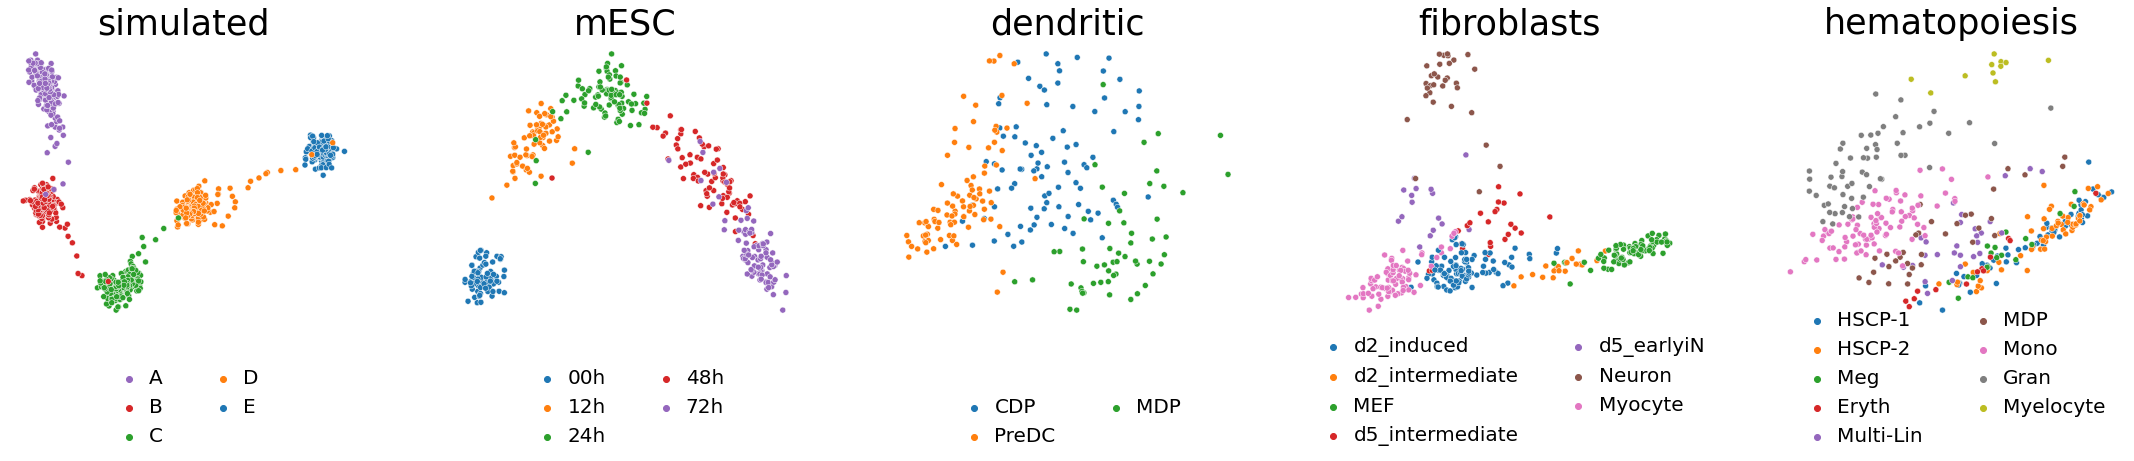

In [8]:
# plot trajectories

# for each, plot colored by branch and pseudotime (also distance from cell 0?)
fig, ax = plt.subplots(**plot_config)


# for icolor_dict, color_dict in enumerate([colors_prosstt, colors_real]):
for itraj, (traj_desc, traj) in enumerate(trajs.items()):
    tl = plot_loc[traj_desc]
    color = 'branch' if is_prosstt(traj_desc) else 'milestone_id'
    palette = palettes[traj_desc]
    title = traj_fignames[traj_desc]
    T.pl.plot_pca2d(traj.pX, meta=traj.meta, color=color, ax=ax[tl], palette=palette, title=title)
    

plt.tight_layout()

In [9]:
exp_desc = 'covariance' # 'covariance' # 
cell_fit = 'sqrt inv pc'
read_fit = 'sqrt inv pt'

# measures to plot
measure_titles = {'Delta0': r'$\Delta$',
                'dmax_psD': r'$max_{kl}{d_{kl}}$', 
                'pt': r'$p_t$',                
                'pc': r'$p_c$',                                
                'nn_dist_psD': r'$\delta$',
                'sqrt inv pt': r'$\frac{1}{\sqrt{p_t}}$', 
                'sqrt inv pc': r'$\frac{1}{\sqrt{p_c}}$',
                'l1': r'$\varepsilon$',
                'ldist': r'$\varepsilon^{dist}$',
                'cov_err': r'$\|C^0 - C\|$'
                }

# # adding log titles
# measure_titles = measure_titles_core.copy()
# for mt, mt_v in measure_titles_core.items():
#     measure_titles[f'log {mt}'] = f'Log {mt_v}'

### Reads downsample (FigS2)
- example of downsample
- Delta(log p_t)
- dij(log p_t) (all?)
- l1(log p_t)

In [10]:
# read L_read
L_read_dict = {}

# L_read_prosstt = pd.read_csv(os.path.join(outdir, 'prosstt_L_reads_single_rep.csv'), index_col=0)
min_log_pt = -8 # TEMP -10 
for dataset in datasets:
    L_read = pd.read_csv(os.path.join(outdir, f'{dataset}_L_reads{exp_desc}.csv'), index_col=0)# TEMP
    L_read = L_read[L_read['log pt'] > min_log_pt]     
    L_read_dict[dataset] = L_read

linear_rep0 $\|C^0 - C\|$ vs $\frac{1}{\sqrt{p_t}}$, coef: [5.09586199e-05], int: 2.0185566186345892e-05
linear_rep0 $\varepsilon_t$ vs $\frac{1}{\sqrt{p_t}}$, coef: [0.00332241], int: 0.02125218927053224
hayashi , coef: [0.00027568], int: -0.00017217173877615444
hayashi , coef: [0.00430071], int: 0.03360580121235073
dendritic , coef: [0.00137834], int: 0.0003390520046447944
dendritic , coef: [0.00187562], int: 0.09025979181752775
fibroblasts , coef: [0.00014545], int: 0.00013807222991177055
fibroblasts , coef: [0.00204313], int: 0.06718327422688335
hematopoiesis , coef: [0.00011792], int: 0.00011473842110456037
hematopoiesis , coef: [0.00200976], int: 0.04840231996107462


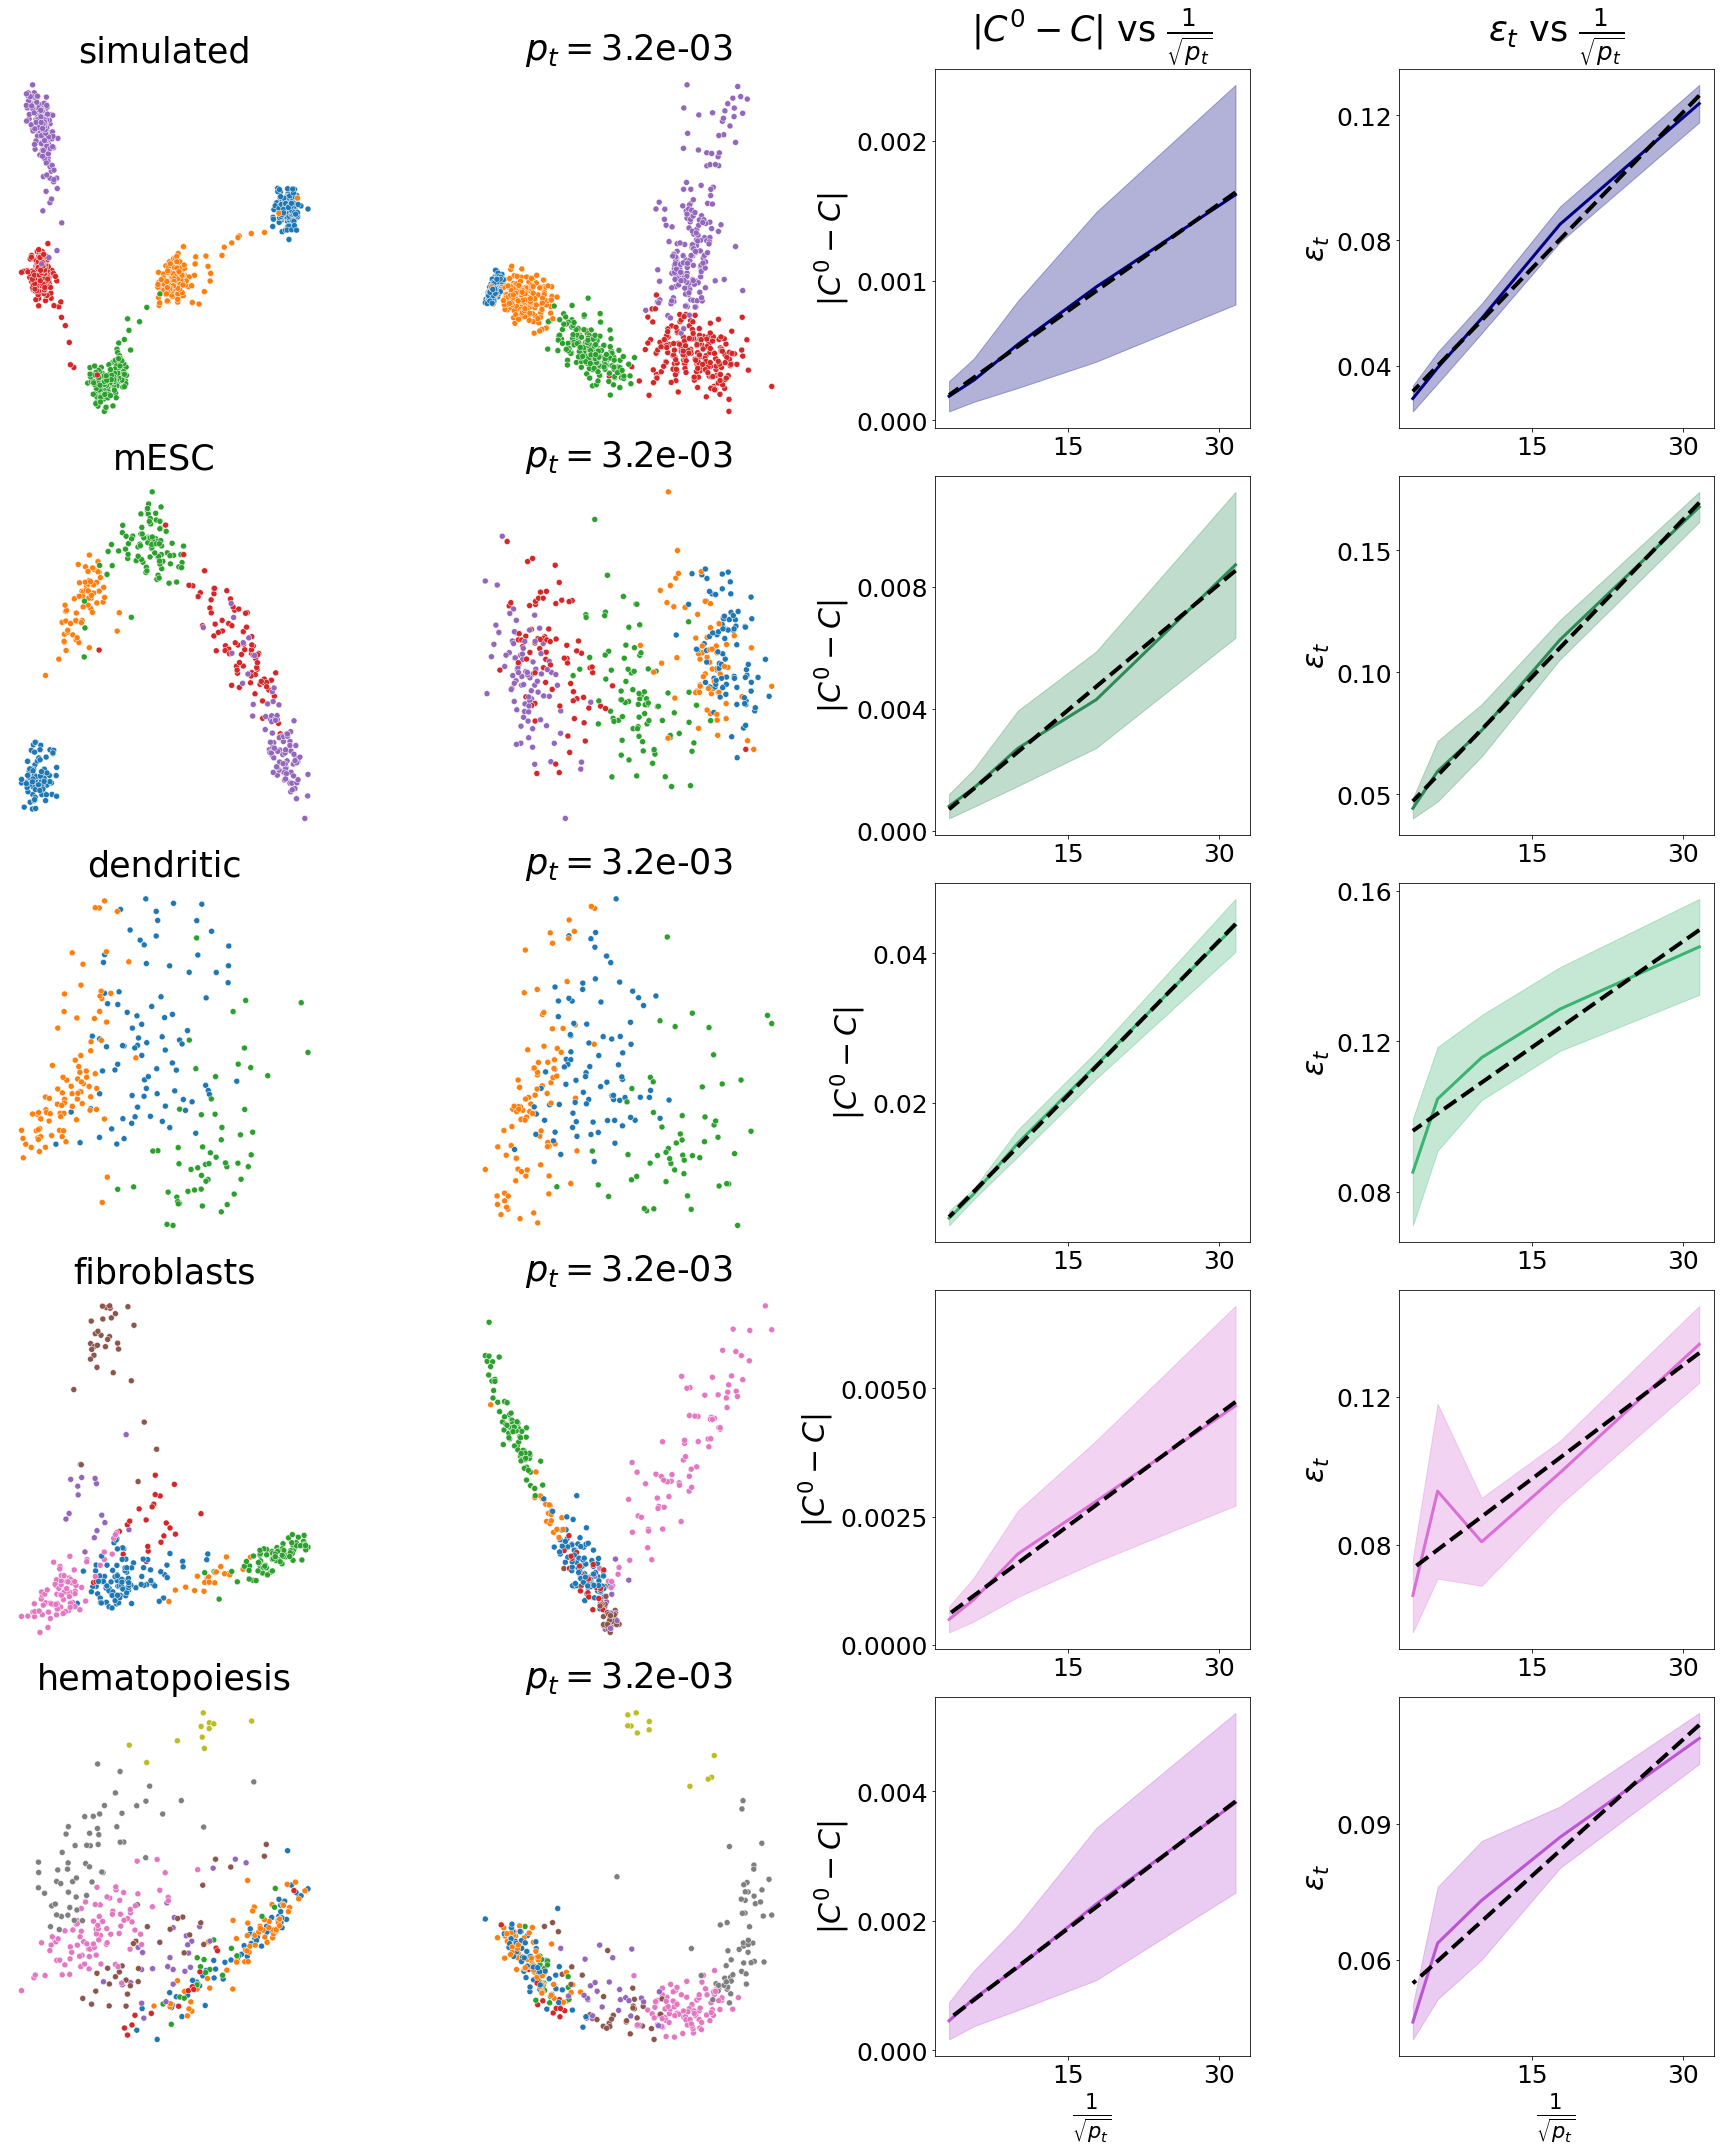

In [11]:
# plot measures
measure_titles['l1'] = r'$\varepsilon_t$'
measure_titles['ldist'] = r'$\varepsilon^{dist}_t$'
plot_std = 1

plot_descs = [ 
    {'xcol': read_fit, 'ycol': 'cov_err', 'add_fit': True},
    {'xcol': read_fit, 'ycol': 'l1', 'add_fit': True},
    ]

ntrajs_pl = 2
nfeatures =  ntrajs_pl + len(plot_descs)
fig, ax = plt.subplots(ntrajs, nfeatures, figsize=(6 * nfeatures, 6*ntrajs))
ax = ax.reshape((1,-1)) if len(ax.shape) == 1 else ax

# xcol = 'log pt'; xlabel = r'$log p_t$'
min_pt = 1e-3
groupby='pt'
model_read_dict = {}
for itraj, (traj_desc, L_read) in enumerate(L_read_dict.items()):

    # plot trajectory
    pt = L_read[L_read['pt'] > min_pt]['pt'].min()
    traj = trajs[traj_desc]
    sX, psX, psD, sD, psP, ix = traj.subsample(pc=1, pt=pt)
    color = 'branch' if is_prosstt(traj_desc) else 'milestone_id'
    palette = palettes[traj_desc]
    stitle = r'$p_t=$' + "{:.1e}".format(pt)
    title = traj_fignames[traj_desc]
    T.pl.plot_pca2d(traj.pX, meta=traj.meta, color=color, ax=ax[itraj,0], title=title, legend=False, palette=palette) # true for subsample
    T.pl.plot_pca2d(psX, meta=traj.meta.iloc[ix], color=color, ax=ax[itraj,1], title=stitle, legend=False, palette=palette)

    color = colors[traj_desc]

    for ipl, plot_desc in enumerate(plot_descs):
        sax = ax[itraj, ntrajs_pl + ipl]
        ycol= plot_desc['ycol']; 
        xcol = plot_desc['xcol']; 
        ylabel = measure_titles[ycol] if ycol in measure_titles.keys() else ycol
        xlabel = measure_titles[xcol] if xcol in measure_titles.keys() else xcol
        title = f'{ylabel} vs {xlabel}' if itraj == 0 else ''
        xlabel = xlabel if itraj == (ntrajs - 1) else ''
        T.pl.plot_tradeoff(L_read, xcol=xcol, ycol=ycol, ylabel=ylabel, xlabel=xlabel, plot_std=plot_std, ax=sax, color_mean=color, color_std=color, title=title, groupby=groupby)
        if 'ylim' in plot_desc.keys():
            sax.set_ylim(bottom=plot_desc['ylim'])
        if 'add_fit' in plot_desc.keys() and plot_desc['add_fit']:
            model_ = linear_model.LinearRegression()
            model_.fit(L_read[[xcol]], L_read[ycol])
            print(fr'{traj_desc} {title}, coef: {model_.coef_}, int: {model_.intercept_}')
            sax.plot(L_read[xcol], model_.predict(L_read[[xcol]]), color='black', linewidth=4, linestyle='--')

    # save fit of reconstruction error
    model_read = linear_model.LinearRegression()
    model_read.fit(L_read[[read_fit]], L_read['l1'])
    model_read_dict[traj_desc] = model_read
    
plt.tight_layout()

### Conclusions
- log max path, log Delta0, log Delta ~ log pt - big distances indeed shrink by this factor
- then both, nn dist and l1 harder to say if log or not

## Cell downsample
- example of downsample
- Delta(log p_t)
- dij(log p_t) (all or shortest dist only?)
- l1(log p_t)

In [12]:
# cell L_cell
L_cell_dict = {}

# min_pc = -2
for dataset in datasets:
    L_cell = pd.read_csv(os.path.join(outdir, f'{dataset}_L_cells{exp_desc}.csv'), index_col=0) # TODO: TEMP
    # L_cell = L_cell[L_cell['log pc'] > min_pc]
    L_cell_dict[dataset] = L_cell

linear_rep0 $\|C^0 - C\|$ vs $\frac{1}{\sqrt{p_c}}$, coef: [0.01721124], int: -0.0288881724427648
linear_rep0 $\varepsilon_c$ vs $\frac{1}{\sqrt{p_c}}$, coef: [0.01152713], int: 0.0068982996229861315
hayashi , coef: [0.01244397], int: -0.011168086533627518
hayashi , coef: [0.02359331], int: 0.009475835630484028
dendritic , coef: [0.11089934], int: -0.1346523401766483
dendritic , coef: [0.04458664], int: 0.03735712167182531
fibroblasts , coef: [0.04593123], int: -0.061031197418180166
fibroblasts , coef: [0.02176548], int: 0.0458767056669067
hematopoiesis , coef: [0.04112832], int: -0.05423857365621816
hematopoiesis , coef: [0.02832082], int: 0.048898975143530435


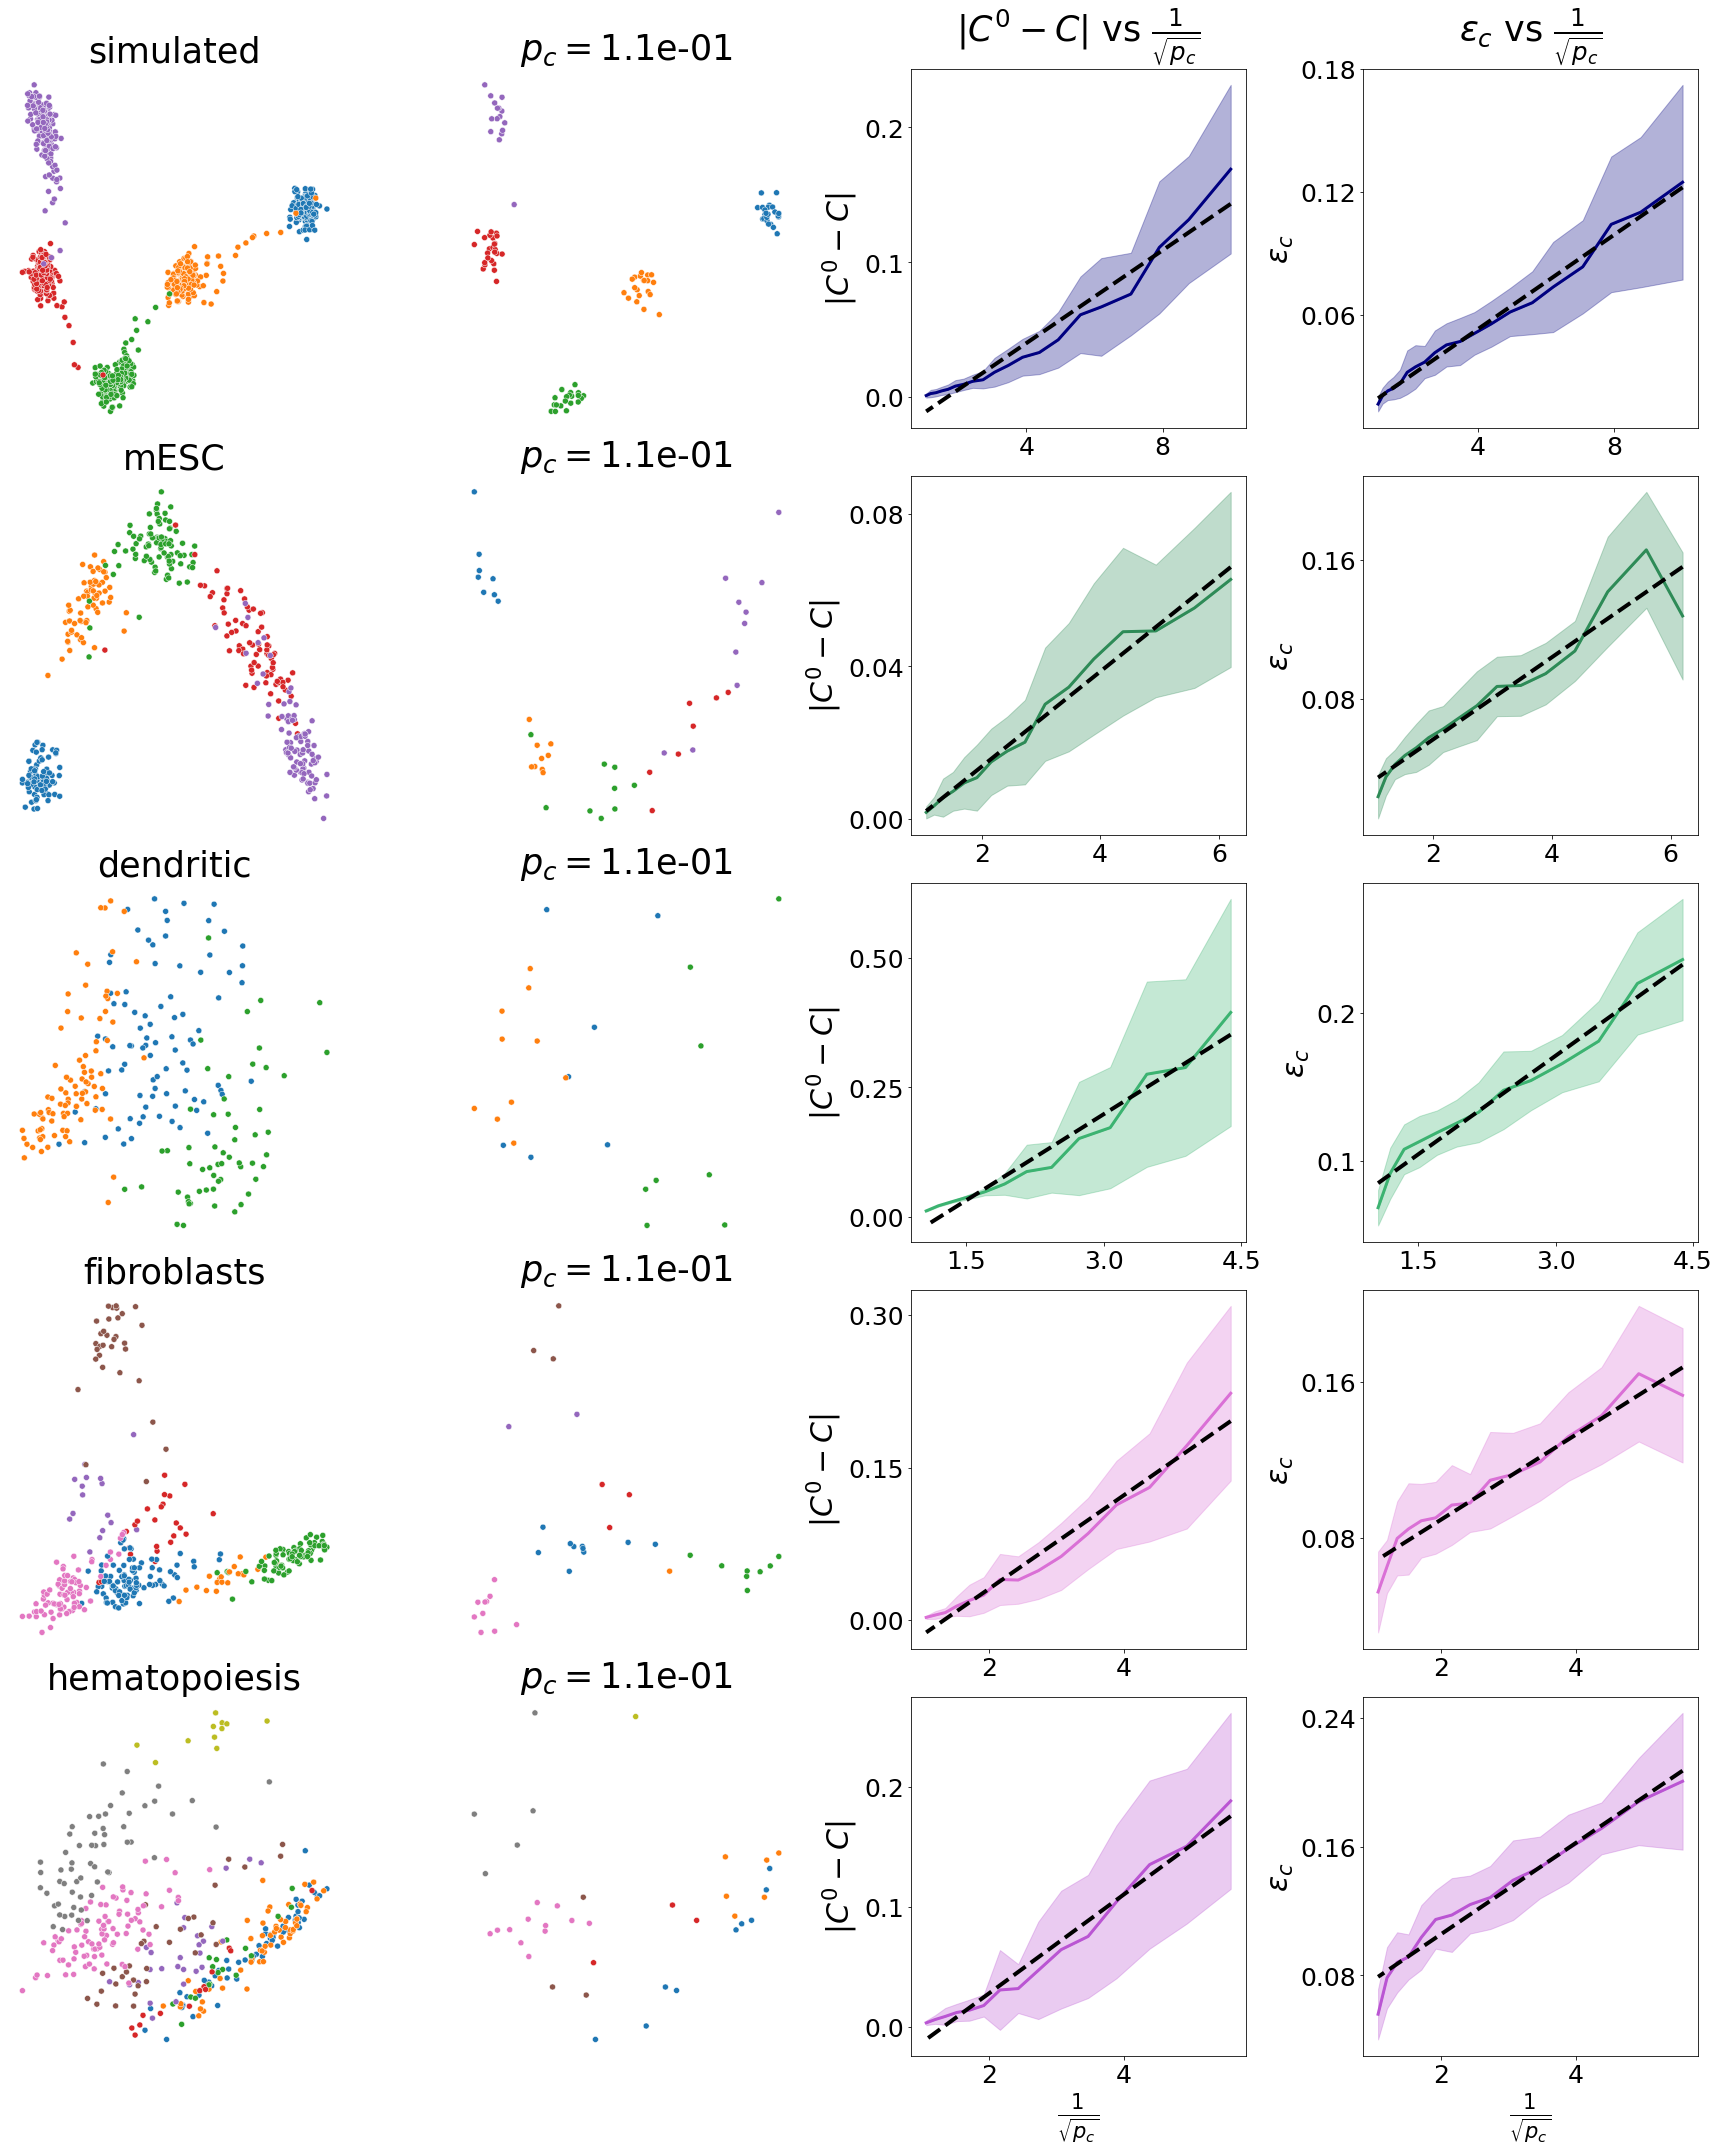

In [13]:
# plot measures
measure_titles['l1'] = r'$\varepsilon_c$'
measure_titles['ldist'] = r'$\varepsilon^{dist}_c$'
plot_std = 1

plot_descs = [ 
    {'xcol': cell_fit, 'ycol': 'cov_err', 'add_fit': True},
    {'xcol': cell_fit, 'ycol': 'l1', 'add_fit': True},
    ]

ntrajs_pl = 2
nfeatures =  ntrajs_pl + len(plot_descs)
fig, ax = plt.subplots(ntrajs, nfeatures, figsize=(6 * nfeatures, 6*ntrajs))
ax = ax.reshape((1,-1)) if len(ax.shape) == 1 else ax
# xcol = 'log pc'; xlabel = r'$log p_t$'
min_pc = 1e-1
groupby = 'pc'
model_cell_dict = {}
for itraj, (traj_desc, L_cell) in enumerate(L_cell_dict.items()):

    # plot trajectory
    pc = L_cell[L_cell['pc'] > min_pc]['pc'].min()
    traj = trajs[traj_desc]
    sX, psX, psD, sD, psP, ix = traj.subsample(pt=1, pc=pc)
    # sample_report = traj.evaluate(sX, psX, psD, sD, psP, ix)
    # sample_report['log pc'] = np.log(pc)
    color = 'branch' if is_prosstt(traj_desc) else 'milestone_id'
    palette = palettes[traj_desc]
    stitle = r'$p_c=$' + "{:.1e}".format(pc)
    title = traj_fignames[traj_desc]
    T.pl.plot_pca2d(traj.pX, meta=traj.meta, color=color, ax=ax[itraj,0], title=title, legend=False, palette=palette) # true for subsample
    T.pl.plot_pca2d(psX, meta=traj.meta.iloc[ix], color=color, ax=ax[itraj,1], title=stitle, legend=False, palette=palette)

    color = colors[traj_desc]

    for ipl, plot_desc in enumerate(plot_descs):
        sax = ax[itraj, ntrajs_pl + ipl]
        ycol= plot_desc['ycol']; 
        xcol = plot_desc['xcol']; 
        ylabel = measure_titles[ycol] if ycol in measure_titles.keys() else ycol
        xlabel = measure_titles[xcol] if xcol in measure_titles.keys() else xcol
        title = f'{ylabel} vs {xlabel}' if itraj == 0 else ''
        xlabel = xlabel if itraj == (ntrajs - 1) else ''
        T.pl.plot_tradeoff(L_cell, xcol=xcol, ycol=ycol, ylabel=ylabel, xlabel=xlabel, plot_std=plot_std, ax=sax, color_mean=color, color_std=color, title=title, groupby=groupby)
        if 'ylim' in plot_desc.keys():
            sax.set_ylim(bottom=plot_desc['ylim'])
        if 'add_fit' in plot_desc.keys() and plot_desc['add_fit']:
            model_ = linear_model.LinearRegression()
            model_.fit(L_cell[[xcol]], L_cell[ycol])
            print(fr'{traj_desc} {title}, coef: {model_.coef_}, int: {model_.intercept_}')
            sax.plot(L_cell[xcol], model_.predict(L_cell[[xcol]]), color='black', linewidth=4, linestyle='--')

    # save fit of reconstruction error
    model_cell = linear_model.LinearRegression()
    model_cell.fit(L_cell[[cell_fit]], L_cell['l1'])
    model_cell_dict[traj_desc] = model_cell
    
plt.tight_layout()

### figure 1 

Text(0.02, 0.5, '$\\varepsilon_c$')

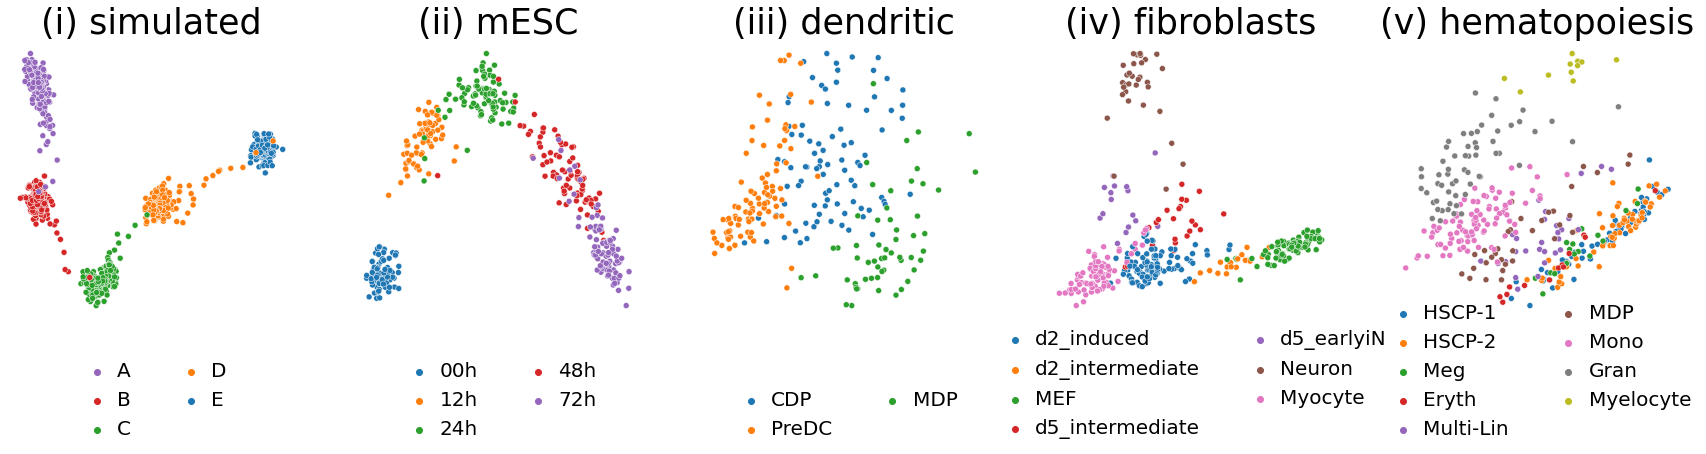

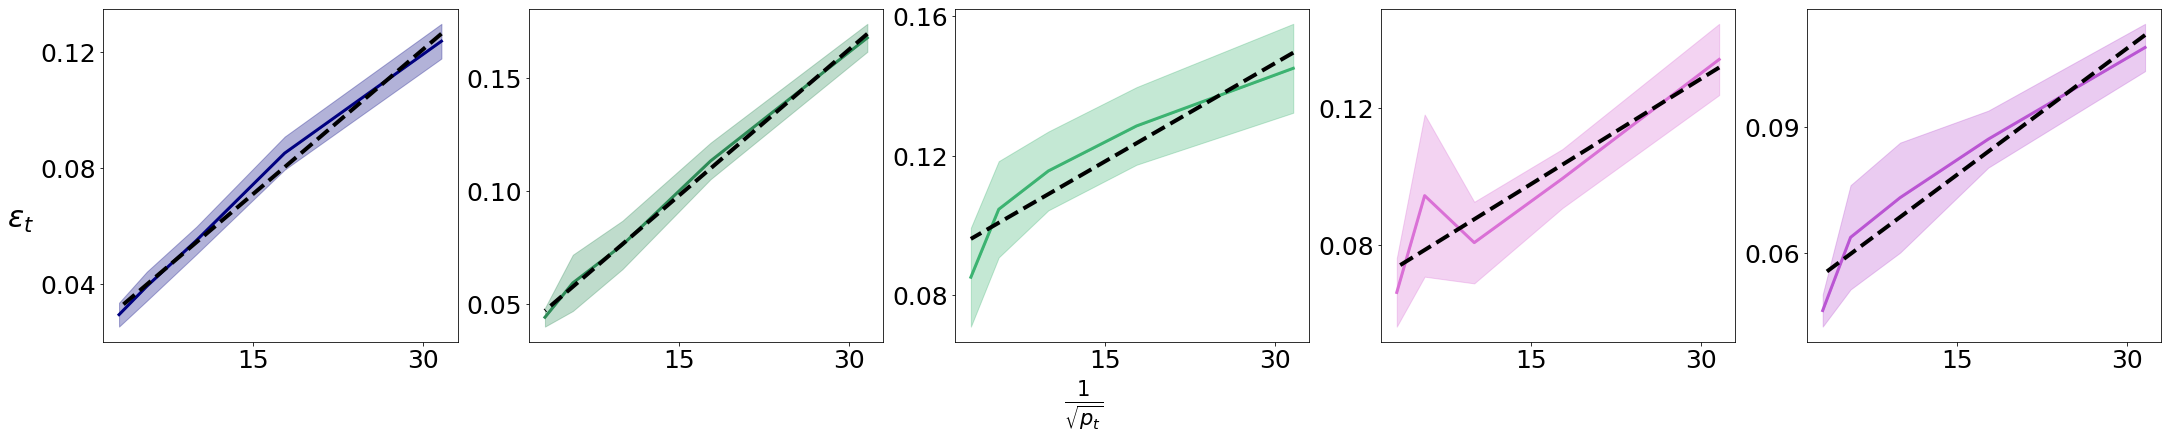

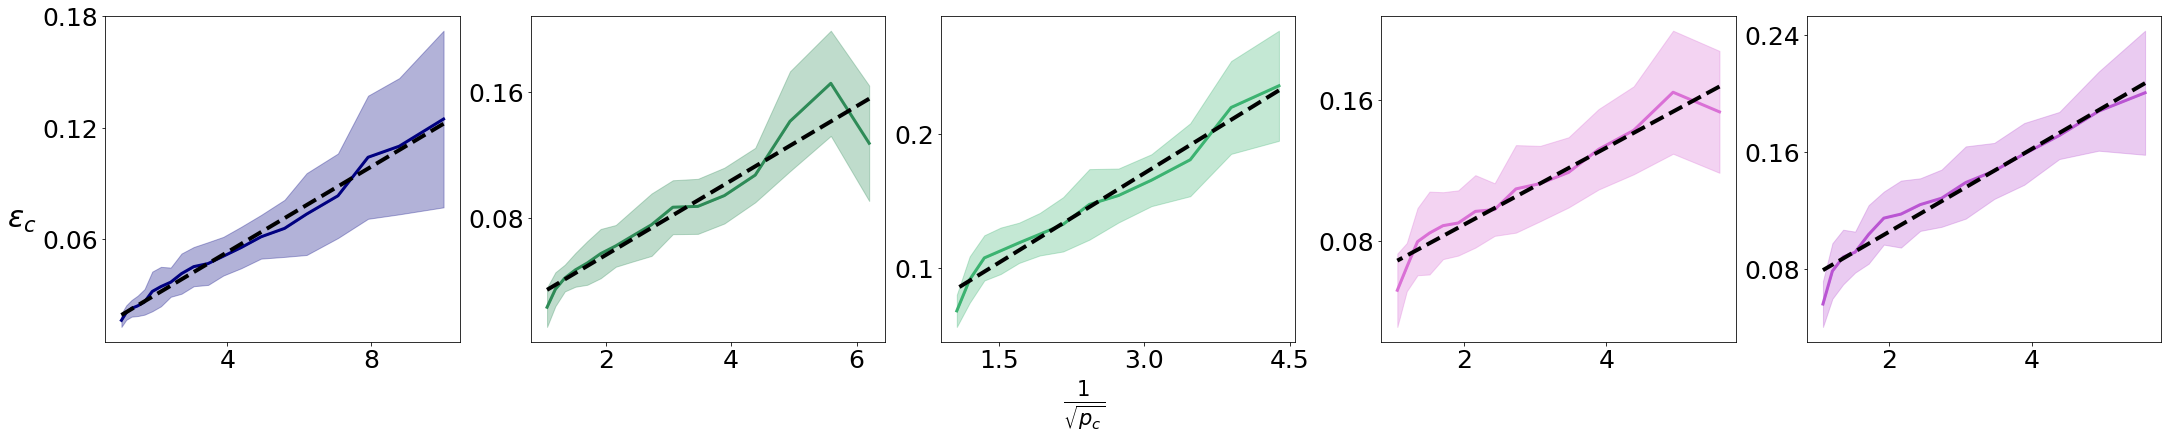

In [14]:
# FIGURE 1 - trajectories, error with pt, error with pc
plot_std = 1
nrows = 1
fig, ax = plt.subplots(nrows, ntrajs, figsize=(6 * ntrajs, 6 * nrows), constrained_layout=True, tight_layout=False)

# plot trajectories
row = 0
legendsize = 25
for itraj, (traj_desc, traj) in enumerate(trajs.items()):
    color = 'branch' if is_prosstt(traj_desc) else 'milestone_id'
    title = f'({T.pl.write_roman(itraj + 1).lower()}) {traj_fignames[traj_desc]}'
    T.pl.plot_pca2d(traj.pX, meta=traj.meta, color=color, ax=ax[itraj], palette=palettes[traj_desc], title=title, legendsize=legendsize)
    
labelsize = 30
titlesize = 30

# plot transcript error
row = 1
title = ''
# ycol='cov_err'; ylabel = measure_titles[ycol]
ycol='l1'; ylabel = r'$\varepsilon_t$'
xcol = read_fit; xlabel = measure_titles[xcol]
fig, ax = plt.subplots(nrows, ntrajs, figsize=(6 * ntrajs, 6 * nrows), constrained_layout=True, tight_layout=False, sharex=True)
for itraj, (traj_desc, L_read) in enumerate(L_read_dict.items()):
    color = colors[traj_desc]
    sax = ax[itraj] # ax[row, itraj]
    model_read = model_read_dict[traj_desc]
    T.pl.plot_tradeoff(L_read, xcol=xcol, ycol=ycol, ylabel='', xlabel='', plot_std=plot_std, ax=sax, color_mean=color, color_std=color, title=title)
    sax.plot(L_read[read_fit], model_read.predict(L_read[[read_fit]]), color='black', linewidth=4, linestyle='--')
fig.supxlabel(xlabel, fontsize=labelsize)
fig.supylabel(ylabel, fontsize=labelsize, rotation=0)


# plot cell error
row = 2
title = ''
# ycol='cov_err'; ylabel = measure_titles[ycol]
ycol='l1'; ylabel = r'$\varepsilon_c$'
xcol = cell_fit; xlabel = measure_titles[xcol]
fig, ax = plt.subplots(nrows, ntrajs, figsize=(6 * ntrajs, 6 * nrows), constrained_layout=True, tight_layout=False)
for itraj, (traj_desc, L_cell) in enumerate(L_cell_dict.items()):
    color = colors[traj_desc]
    sax = ax[itraj] # ax[row, itraj]
    model_cell = model_cell_dict[traj_desc]
    T.pl.plot_tradeoff(L_cell, xcol=xcol, ycol=ycol, ylabel='', xlabel='', plot_std=plot_std, ax=sax, color_mean=color, color_std=color, title=title)
    sax.plot(L_cell[cell_fit], model_cell.predict(L_cell[[cell_fit]]), color='black', linewidth=4, linestyle='--')

fig.supxlabel(xlabel, fontsize=labelsize)
fig.supylabel(ylabel, fontsize=labelsize, rotation=0)            


## Tradeoff

In [15]:
# read tradeoff experiments
L_tradeoff_dict = {}

for dataset in datasets:
    fname = os.path.join(outdir, f'{dataset}_L_tradeoff.csv')
    if os.path.isfile(fname):
        L_tradeoff = pd.read_csv(fname, index_col=0)
        L_tradeoff['sqrt inv pc'] = np.sqrt(1/L_tradeoff['pc'])
        L_tradeoff['sqrt inv pt'] = np.sqrt(1/L_tradeoff['pt'])
        L_tradeoff['sqrt inv pt pc'] = np.sqrt(1/(L_tradeoff['pt'] * L_tradeoff['pc']))
        L_tradeoff = L_tradeoff[L_tradeoff['log pt'] > min_log_pt]# TEMP
        L_tradeoff_dict[dataset] = L_tradeoff

In [16]:
# B = L_tradeoff['B'].unique()[5]
# # plot all trajectories before any processing
# fig, ax = plt.subplots(**plot_config)

# for itraj, (traj_desc, L_tradeoff) in enumerate(L_tradeoff_dict.items()):
#     tl = plot_loc[traj_desc]
#     sL_tradeoff = L_tradeoff[L_tradeoff['B'] == B]
#     stitle = r'$B=$' + "{:.1e}".format(B)
#     T.pl.plot_tradeoff_experiments(L_tradeoff=sL_tradeoff, plot_std=plot_std, plot_pc_opt=False, sharey=False, plot_pcs=False, 
#     colors=colors, ylabel='', axs=ax[itraj], labelsize=25)
#     # ax.set_title(stitle)


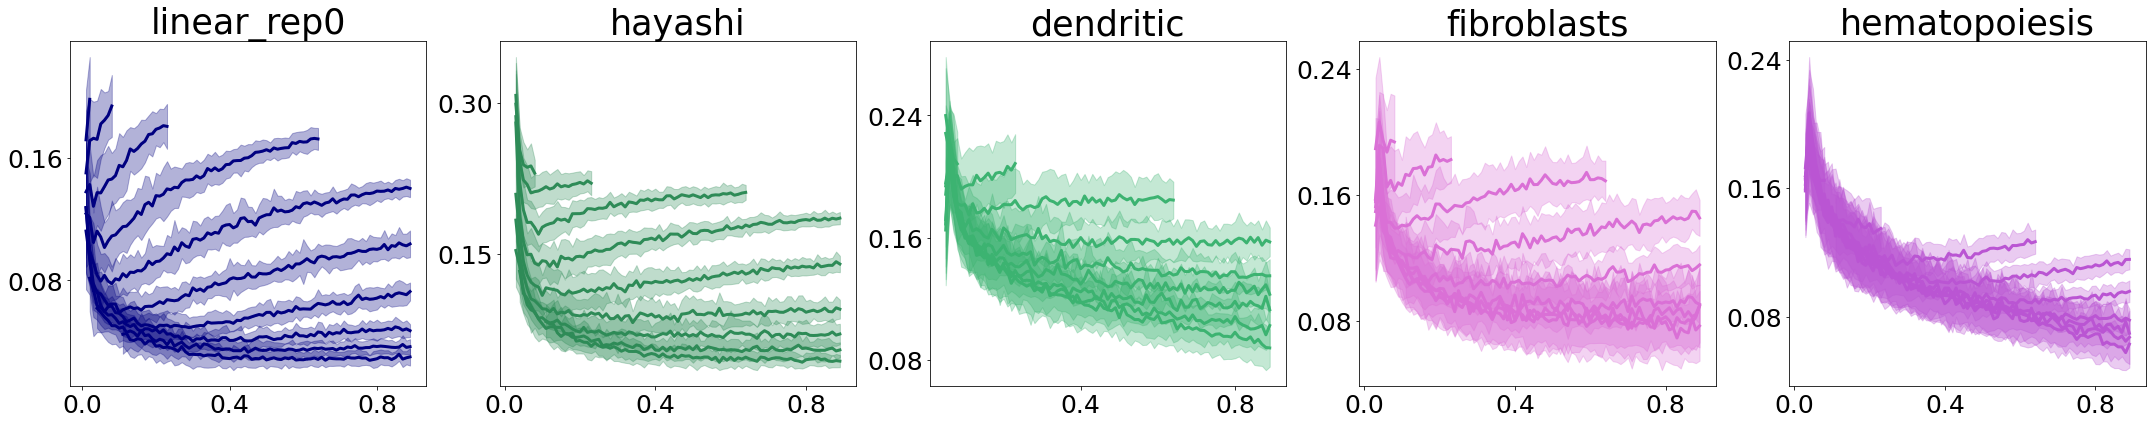

In [17]:
# plot all trajectories before any processing
fig, ax = plt.subplots(**plot_config)
xcol = 'pc'

for traj_desc, L_tradeoff in L_tradeoff_dict.items():
    tl = plot_loc[traj_desc]
    title = traj_fignames[traj_desc]
    T.pl.plot_tradeoff_experiments(L_tradeoff=L_tradeoff, plot_std=plot_std, plot_pc_opt=False, sharey=False, plot_pcs=False, xcol=xcol, 
    colors=colors, ylabel='', axs=ax[tl], labelsize=25, xlabel='', ycol='l1')


In [18]:
# smoothing sampling results
rL_tradeoff_dict = {}
roll = 4

for traj_desc, L_tradeoff in L_tradeoff_dict.items():
    rL_tradeoff = T.pl.smooth_tradeoff(L_tradeoff, roll=roll)
    rL_tradeoff['trajectory type'] = L_tradeoff['trajectory type'].iloc[0]
    rL_tradeoff_dict[traj_desc] = rL_tradeoff

L_tradeoff_dict = rL_tradeoff_dict

Text(0.02, 0.5, '$\\varepsilon$')

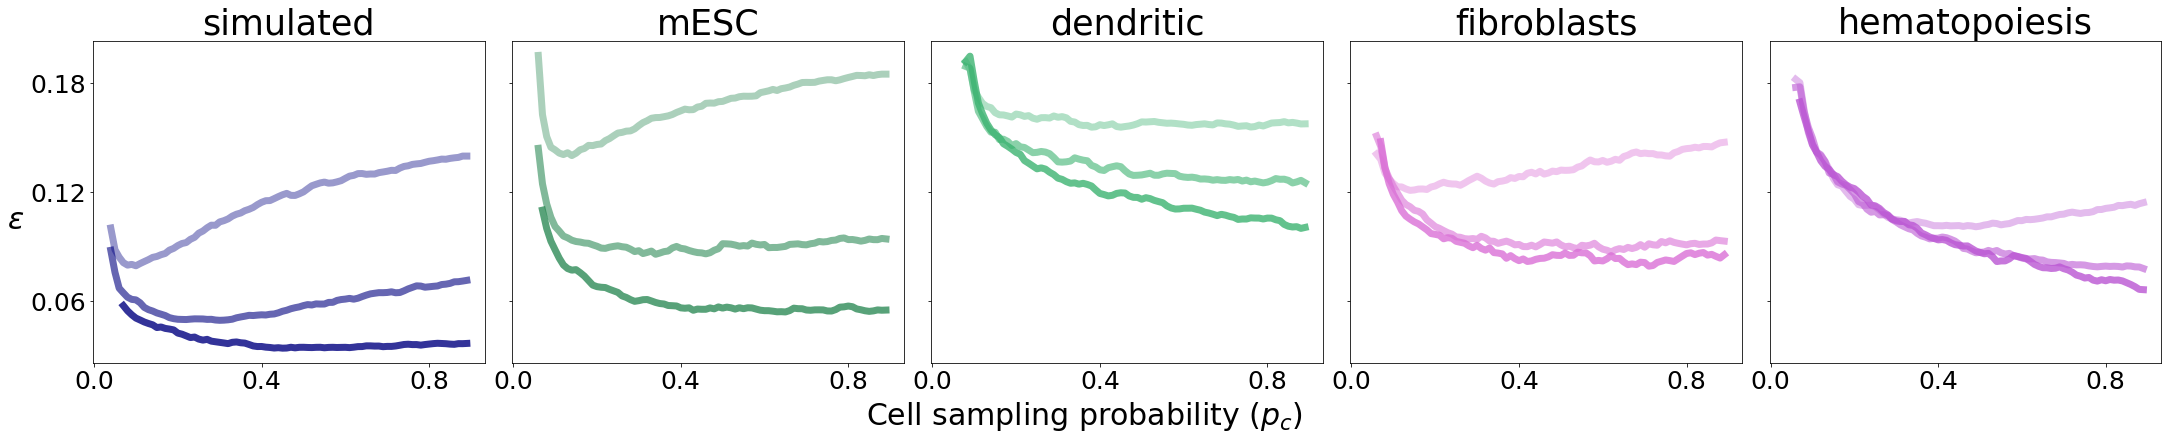

In [19]:
# plot tradeoff
plot_std = 1
xcol = 'pc'
ycol='l1'; ylabel = r'$\varepsilon$'
fig, ax = plt.subplots(**plot_config, sharex=True, sharey=True) #, constrained_layout=True, tight_layout=False

Bs = L_tradeoff['B'].unique()
Bs_pl = Bs[3:-1:2]
nBs_pl = len(Bs_pl)
for itraj, (traj_desc, L_tradeoff) in enumerate(L_tradeoff_dict.items()):
    tl = plot_loc[traj_desc]
    title = traj_fignames[traj_desc]
    color = colors[traj_desc]
    for iB,B in enumerate(Bs_pl):
        sL_tradeoff = L_tradeoff[L_tradeoff['B'] == B]
        alpha = (iB+2) / (nBs_pl+2)
        T.pl.plot_tradeoff(sL_tradeoff, xcol=xcol, ycol=ycol, ylabel='', xlabel='', plot_std=plot_std, ax=ax[tl], color_mean=color, color_std=color, 
        alpha=alpha, title=title, linewidth=7)
    
# fig.suptitle('Reconstruction error under constant sequencing budget', fontsize=titlesize)
labelsize = 30
ylabel = r'$\varepsilon$'
xlabel = r'Cell sampling probability ($p_c$)'
fig.supxlabel(xlabel, fontsize=labelsize)
fig.supylabel(ylabel, fontsize=labelsize, rotation=0)


Neither
Neither
Neither
Neither
Neither
Neither
Neither
Neither
Neither
Neither
Neither
Neither
Neither
Neither
Neither


Text(0.5, 0.98, 'Tradeoff ')

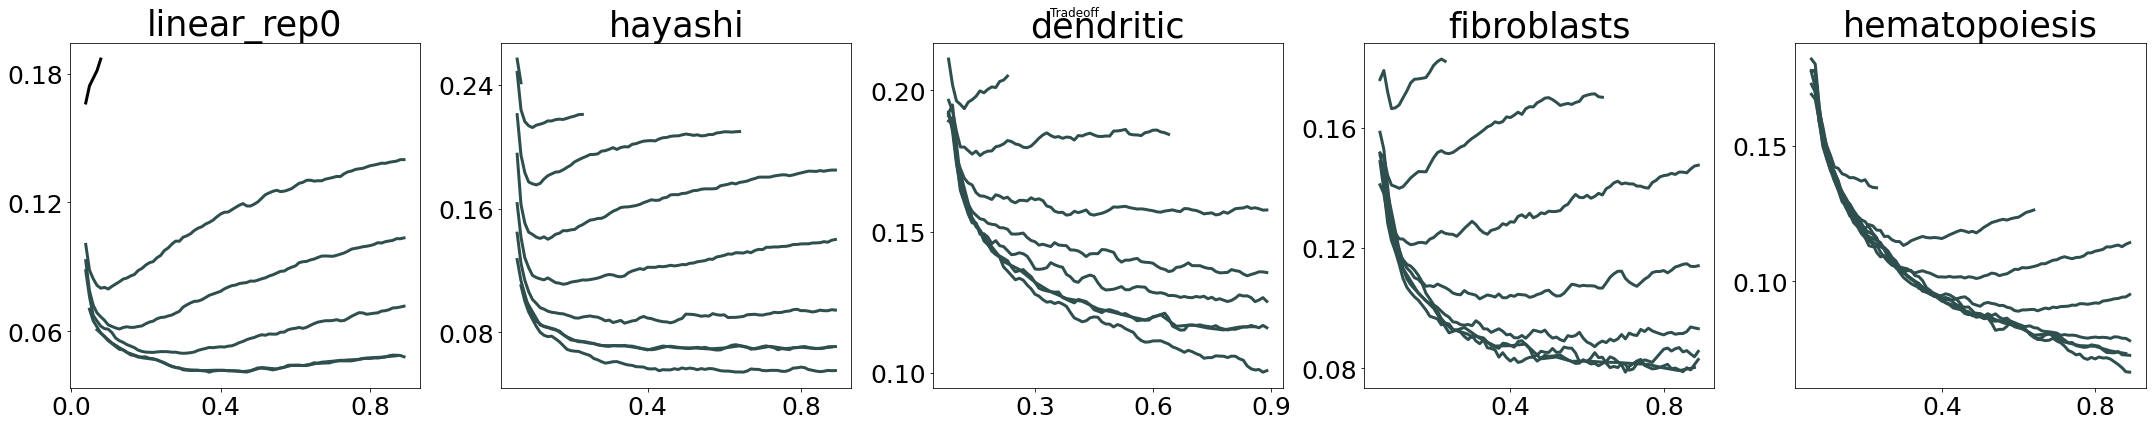

In [37]:
# plotting empirically monotonic increasing/decreasing
plot_std = 0
xcol = 'pc'
color_cell_better = 'black'
color_read_better = 'darkslategray'
fig, ax = plt.subplots(**plot_config)
min_seq_locations = 1
min_diff = 5e-3

kwargs = {'plot_std': plot_std,
         'plot_pc_opt': False,
         'sharey': False,
         'plot_pcs': False,
         'xcol': xcol,
         'xlabel': '',
         'ylabel': '',
         }

for dataset, L_tradeoff in L_tradeoff_dict.items():
    tl = plot_loc[dataset]
    L_grp = L_tradeoff.groupby(['B'])

    for B, sL in L_grp:
        vals = T.pl.check_increase_decrease(sL['pc'], sL['l1'], min_seq_locations=min_seq_locations, min_diff=min_diff)

        is_decreasing = 'decreasing' in vals
        is_increasing = 'increasing' in vals
        if is_increasing and not is_decreasing:
            T.pl.plot_tradeoff_experiments(L_tradeoff=sL, color=color_cell_better, axs=ax[tl], **kwargs)
        elif not is_increasing and is_decreasing:
            T.pl.plot_tradeoff_experiments(L_tradeoff=sL, color=color_read_better, axs=ax[tl], **kwargs)
        elif is_increasing and is_decreasing:
            T.pl.plot_tradeoff_experiments(L_tradeoff=sL, colors=colors, axs=ax[tl], **kwargs)
        else:
            print('Neither')

plt.suptitle('Tradeoff ')

## Modeling reconstruction error

In [21]:
def softmax_max(xs, a=10):
    xs = np.array(xs)
    e_ax = np.exp(a * xs)
    return xs @ e_ax.T / np.sum(e_ax)

In [22]:
# from scipy.optimize import fmin

# dataset = 'linear'
# L_tradeoff = L_tradeoff_dict[dataset]
# model_read = model_read_dict[dataset]
# model_cell = model_cell_dict[dataset]

# B = Bs[0]

# def compute_softmax(pc):
#     pt = B/pc
#     pred_cell_col = model_cell.predict(np.log([pc]))
#     pred_read_col = model_read.predict(np.log([pt]))
#     return softmax_max((pred_cell_col[0], pred_read_col[0]), a=20)

# pc0 = 0.1
# pcmin = fmin(compute_softmax, pc0)

Text(0.02, 0.5, '$\\varepsilon$')

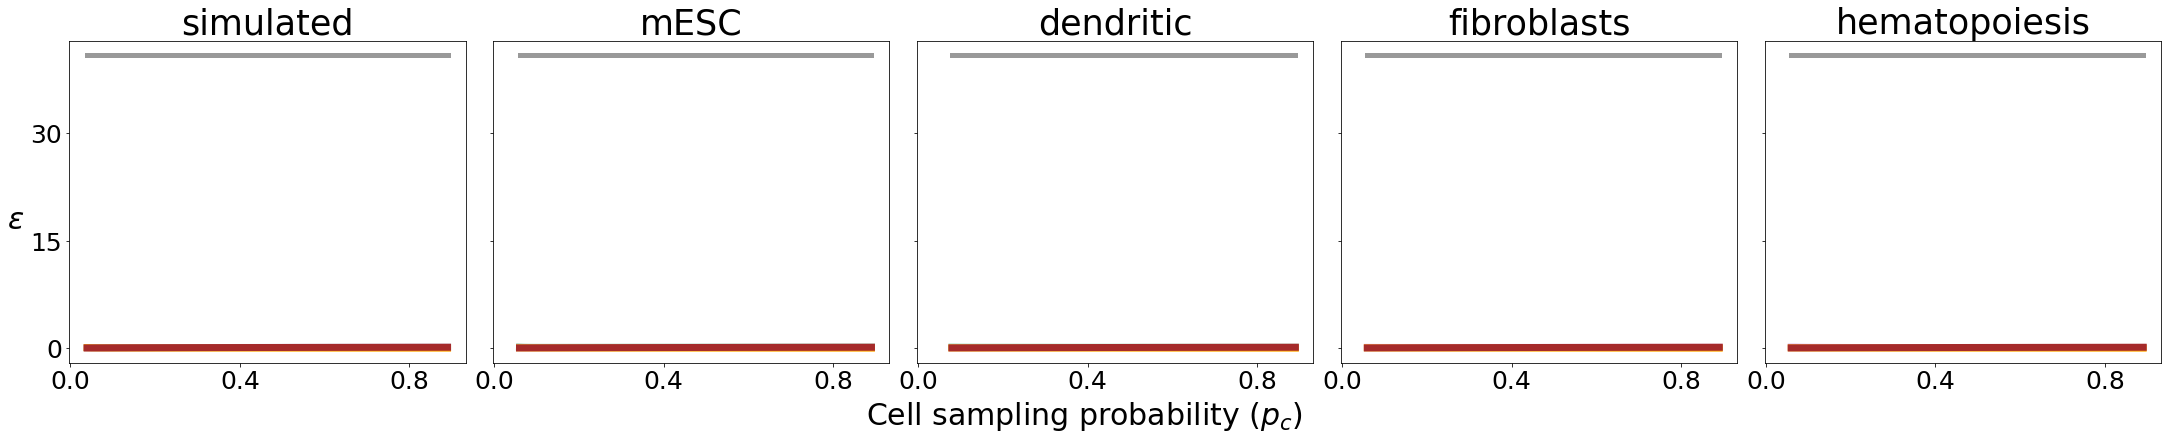

In [34]:
# plot tradeoff
plot_std = 0
xcol = 'pc'
fig, ax = plt.subplots(**plot_config, sharex=True, sharey=True)
pred_cell_col = 'pred cell l1' # 'pred cell l1'
pred_read_col = 'pred read l1'

B_min = 0.0001

color_cell = 'orange'
color_read = 'brown'

for itraj, (traj_desc, L_tradeoff) in enumerate(L_tradeoff_dict.items()):
    
    tl = plot_loc[traj_desc]
    title = traj_fignames[traj_desc]
    color = colors[traj_desc]

    model_read = model_read_dict[dataset]
    model_cell = model_cell_dict[dataset]
    
    L_tradeoff[pred_cell_col] = model_cell.predict(L_tradeoff[[cell_fit]])
    L_tradeoff[pred_read_col] = model_read.predict(L_tradeoff[[read_fit]])

    # L_tradeoff['pred l1'] = L_tradeoff['sqrt inv pt pc']
    # L_tradeoff['pred l1'] = L_tradeoff[pred_cell_col] * L_tradeoff[pred_read_col]
    # L_tradeoff['pred l1'] = L_tradeoff[pred_cell_col] + L_tradeoff[pred_read_col]
    L_tradeoff['pred l1'] = L_tradeoff.apply(lambda row: softmax_max((row[pred_cell_col], row[pred_read_col]), a=10), axis=1)    

    a = model_read.intercept_.take(0)
    b = -model_read.coef_.take(0)
    alpha = model_cell.intercept_.take(0)
    beta = -model_cell.coef_.take(0)


    for iB,B in enumerate(Bs_pl):
        sL_tradeoff = L_tradeoff[L_tradeoff['B'] == B]
        alpha_col = (iB+2) / (nBs_pl+2)

        T.pl.plot_tradeoff(sL_tradeoff, xcol=xcol, ycol=ycol, ylabel='', xlabel='', plot_std=plot_std, ax=ax[tl], color_mean=color, color_std=color, 
        alpha=alpha_col, title=title, linewidth=7)
        
        T.pl.plot_tradeoff(sL_tradeoff, xcol=xcol, ycol='pred l1', ylabel='', xlabel='', plot_std=plot_std, ax=ax[tl], color_mean='black', color_std=color, 
        alpha=alpha_col, title=title, linewidth=5)
        
        T.pl.plot_tradeoff(sL_tradeoff, xcol=xcol, ycol=pred_cell_col, ylabel='', xlabel='', plot_std=plot_std, ax=ax[tl], 
        color_mean=color_cell, linewidth=7)
        
        T.pl.plot_tradeoff(sL_tradeoff, xcol=xcol, ycol=pred_read_col, ylabel='', xlabel='', plot_std=plot_std, ax=ax[tl], 
        color_mean=color_read, linewidth=7)

        # A = -(a-alpha)/(beta+b)
        # C = b / (beta+b)
        # pc_min_pred = np.exp(A)*np.power(B, C)
        # ax[tl].axvline(x=pc_min_pred, color='red', linewidth=3, linestyle='--')
        break
        

labelsize = 30
ylabel = r'$\varepsilon$'
xlabel = r'Cell sampling probability ($p_c$)'
fig.supxlabel(xlabel, fontsize=labelsize)
fig.supylabel(ylabel, fontsize=labelsize, rotation=0)

In [40]:
L_tradeoff[['sqrt inv pt pc', 'l1']]
c = L_tradeoff['l1'].max() / L_tradeoff['sqrt inv pt pc'].max()
L_tradeoff['scaled sqrt inv pt pc'] = L_tradeoff['sqrt inv pt pc'] * c

Text(0.5, 1.0, 'softmax')

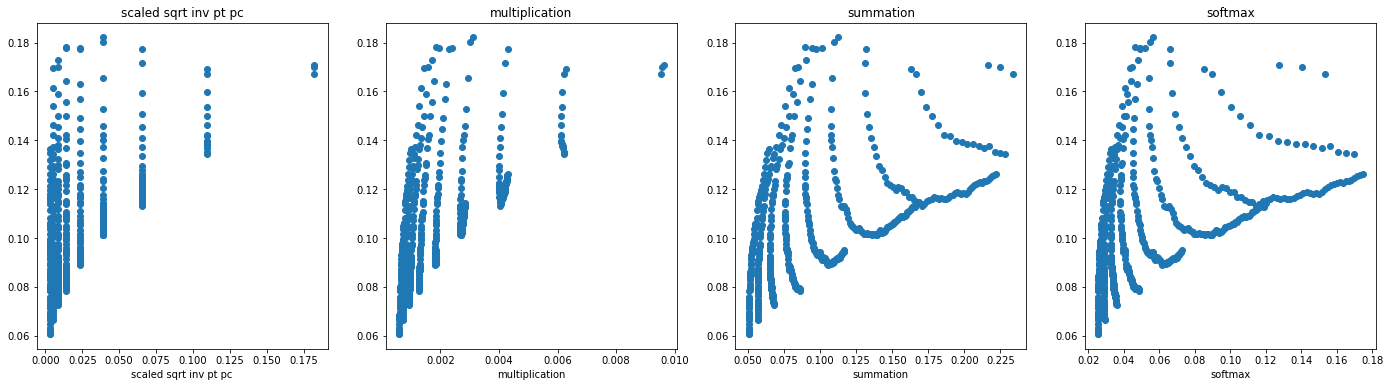

In [41]:
fig, ax = plt.subplots(1,4, figsize=(24,6))
sf = L_tradeoff.apply(lambda row: softmax_max((row[pred_cell_col], row[pred_read_col]), a=10), axis=1)    
xlabel='scaled sqrt inv pt pc'
ax[0].scatter(L_tradeoff['scaled sqrt inv pt pc'], L_tradeoff['l1']); ax[0].set_xlabel(xlabel); ax[0].set_title(xlabel)
xlabel='multiplication'
ax[1].scatter(L_tradeoff[pred_cell_col] * L_tradeoff[pred_read_col], L_tradeoff['l1']); ax[1].set_xlabel(xlabel); ax[1].set_title(xlabel)
xlabel='summation'
ax[2].scatter(L_tradeoff[pred_cell_col] + L_tradeoff[pred_read_col], L_tradeoff['l1']); ax[2].set_xlabel(xlabel); ax[2].set_title(xlabel)
xlabel='softmax'
ax[3].scatter(sf, L_tradeoff['l1']); ax[3].set_xlabel(xlabel); ax[3].set_title(xlabel)


In [24]:
# traj_desc = 'linear_rep0'
# L_tradeoff = L_tradeoff_dict[traj_desc]

# fig,ax = plt.subplots(1,2, figsize=(6,12))
# ax[0].scatter(L_tradeoff[[cell_fit]], model_cell.predict(L_tradeoff[[cell_fit]]))
# ax[0].scatter(L_cell[[cell_fit]], model_cell.predict(L_cell[[cell_fit]]))
# ax[0].scatter(L_tradeoff[[cell_fit]], L_tradeoff['l1'])
# ax[0].scatter(L_cell[[cell_fit]], L_cell['l1'])

# ax[1].scatter(L_tradeoff[[read_fit]], model_read.predict(L_tradeoff[[read_fit]]))
# ax[1].scatter(L_read[[read_fit]], model_read.predict(L_read[[read_fit]]))
# ax[1].scatter(L_tradeoff[[read_fit]], L_tradeoff['l1'])
# ax[1].scatter(L_read[[read_fit]], L_read['l1'])

# # print(model_cell.predict(L_tradeoff[[cell_fit]]))

In [25]:
# plot prediction and actual of tradeoff features
# x axis - B, y axis - pc
# mark boundaries where we predict monotonic and where actually found to be monotonic (monotonic score?)
# point where we predict minimum to be and where min is empirically at


Can see that looking at the max error does not combine well the errors. 

$$\frac{\varepsilon_t e^{s\varepsilon_t} + \varepsilon_c e^{s\varepsilon_c}}{e^{s\varepsilon_t}+e^{s\varepsilon_c}}$$

$$\frac{(\alpha + \beta\log \frac{B}{p_c})) e^{s(\alpha + \beta\log \frac{B}{p_c}))} + (a + b\log p_c) e^{s(a + b\log p_c)}}{e^{s(\alpha + \beta\log \frac{B}{p_c}))}+e^{s(a + b\log p_c)}}$$


$$\frac{(\alpha + \beta\log \frac{B}{x})) e^{s(\alpha + \beta\log \frac{B}{x}))} + (a + b\log x) e^{s(a + b\log x)}}{e^{s(\alpha + \beta\log \frac{B}{x}))}+e^{s(a + b\log x)}}$$


## Directly fitting tradeoff curves with model

In [26]:
# import numpy as np
# from scipy.optimize import curve_fit

# def pred_l1_func(logpc_logpt, a,b,c):
#     logpc, logpt = logpc_logpt
#     return np.maximum(a*logpc, c*logpt) + b

# # plot tradeoff
# plot_std = 0
# xcol = 'pc'
# fig, ax = plt.subplots(**plot_config)
# pred_cell_col = 'pred cell l1' # 'pred cell l1'
# pred_read_col = 'pred read l1'

# # p0 = 0.1,0.1,0.1

# for itraj, (dataset, L_tradeoff) in enumerate(L_tradeoff_dict.items()):
#     tl = plot_loc[dataset]
#     T.pl.plot_tradeoff_experiments(L_tradeoff=L_tradeoff, plot_std=plot_std, plot_pc_opt=False, sharey=False, plot_pcs=False, xcol=xcol, colors=colors, axs=ax[tl])
    
#     logpc_logpt = (L_tradeoff['log pc'].values, L_tradeoff['log pt'].values)
#     l1 = L_tradeoff['l1'].values

#     model_read = model_read_dict[dataset]
#     model_cell = model_cell_dict[dataset]
    
#     a = model_cell.coef_.take(0)
#     b = model_cell.intercept_.take(0)
#     c = model_read.coef_.take(0)
    
#     p0 = a,b,c
#     res = curve_fit(pred_l1_func, logpc_logpt, l1, p0)
#     L_tradeoff['pred l1 model'] = pred_l1_func(logpc_logpt, *res[0])

#     T.pl.plot_tradeoff_experiments(L_tradeoff, plot_std=plot_std, plot_pc_opt=False, sharey=False, plot_pcs=False, xcol='pc', ycol='pred l1 model', axs=ax[tl])
    
# plt.suptitle(r'Fitted as a $\max(a*\log(p_t), b*\log(p_c)) + c$')
# plt.tight_layout()



# # logpc_logpt = (L_tradeoff['log pc'].values, L_tradeoff['log pt'].values)
# # l1 = L_tradeoff['l1'].values

# # # initial guesses for a,b,c,d,e
# # a = model_cell.coef_.take(0)
# # b = model_cell.intercept_.take(0)
# # c = model_read.coef_.take(0)
# # d = model_read.intercept_.take(0)
# # e = 0.0001
# # # p0 = a,b,c,d,e
# # # p0 = a,b,c #,d,e
# # p0 = 0.1,0.1,0.1
# # print(p0)

# # res = curve_fit(pred_l1_func, logpc_logpt, l1, p0)
# # L_tradeoff['pred l1 model'] = pred_l1_func(logpc_logpt, *res[0])

# # fig,ax = plt.subplots(1,1, figsize=(6,6))
# # T.pl.plot_tradeoff_experiments(L_tradeoff=L_tradeoff, plot_std=plot_std, plot_pc_opt=False, sharey=False, plot_pcs=False, xcol=xcol, colors=colors, axs=ax)



# # T.pl.plot_tradeoff_experiments(L_tradeoff, plot_std=plot_std, plot_pc_opt=False, sharey=False, plot_pcs=False, xcol='pc', ycol='pred l1 model', axs=ax)
    

## Tradeoff Regime and Minimization
- a "tradeoff" - where l1_cell_pred and l1_read_pred are both maximal (maybe plot l1 max cell/read as a function of B)
- in terms of B, for which budget do we expect a "tradeoff"?
- can check where the function minimum is at, or
- test whether for a given B, at very low pc (where we expect read error to be at its best) $\varepsilon_t>\varepsilon_c$
- and at high pc evaluated as $\varepsilon_t<\varepsilon_c$:

\begin{gather*}
    \begin{array}{lr}
        only cells, & \varepsilon_t(B,p_c->0) > \varepsilon_c(B,p_c->0)\\
        tradeoff, & otherwise\\
        only reads, & \varepsilon_t(B,p_c->1) < \varepsilon_c(B,p_c->1)\\
        \end{array}
\end{gather*}



For limits of $p_c$:
\begin{gather*}
    \begin{array}{lr}
        only cells, & B < e^A {p^{min}_c}^C\\
        tradeoff, & otherwise\\
        only reads, & B > e^A {p^{max}_c}^C\\
        \end{array}
\end{gather*}

where $\varepsilon_t = a-b\log \frac{B}{p_c}$, $\varepsilon_t = \alpha-\beta\log p_c$
and $A=\frac{a-\alpha}{b}, C=\frac{\beta+b}{b}$


- when there is a tradeoff, where is the minimum?

a: 0.02125218927053224, b: -0.003322405954729305, $\alpha$: 0.0068982996229861315, $\beta$: -0.011527132262852558
Blow: 7.509186011443512e-09, Bhigh: 0.007897734589113114
a: 0.03360580121235073, b: -0.004300712246646764, $\alpha$: 0.009475835630484028, $\beta$: -0.023593309607264593
Blow: 4.3502084986330117e-11, Bhigh: 0.0017181311684143258
a: 0.09025979181752775, b: -0.0018756221528218628, $\alpha$: 0.03735712167182531, $\beta$: -0.04458663752790089
Blow: 3.7868467453882894e-40, Bhigh: 3.139481602395559e-14
a: 0.06718327422688335, b: -0.0020431302423166114, $\alpha$: 0.0458767056669067, $\beta$: -0.021765475688798455
Blow: 1.7092151813974196e-19, Bhigh: 7.607592686507689e-06
a: 0.04840231996107462, b: -0.0020097648430396397, $\alpha$: 0.048898975143530435, $\beta$: -0.02832082403938909
Blow: 4.65219034526591e-19, Bhigh: 0.2205651943079284


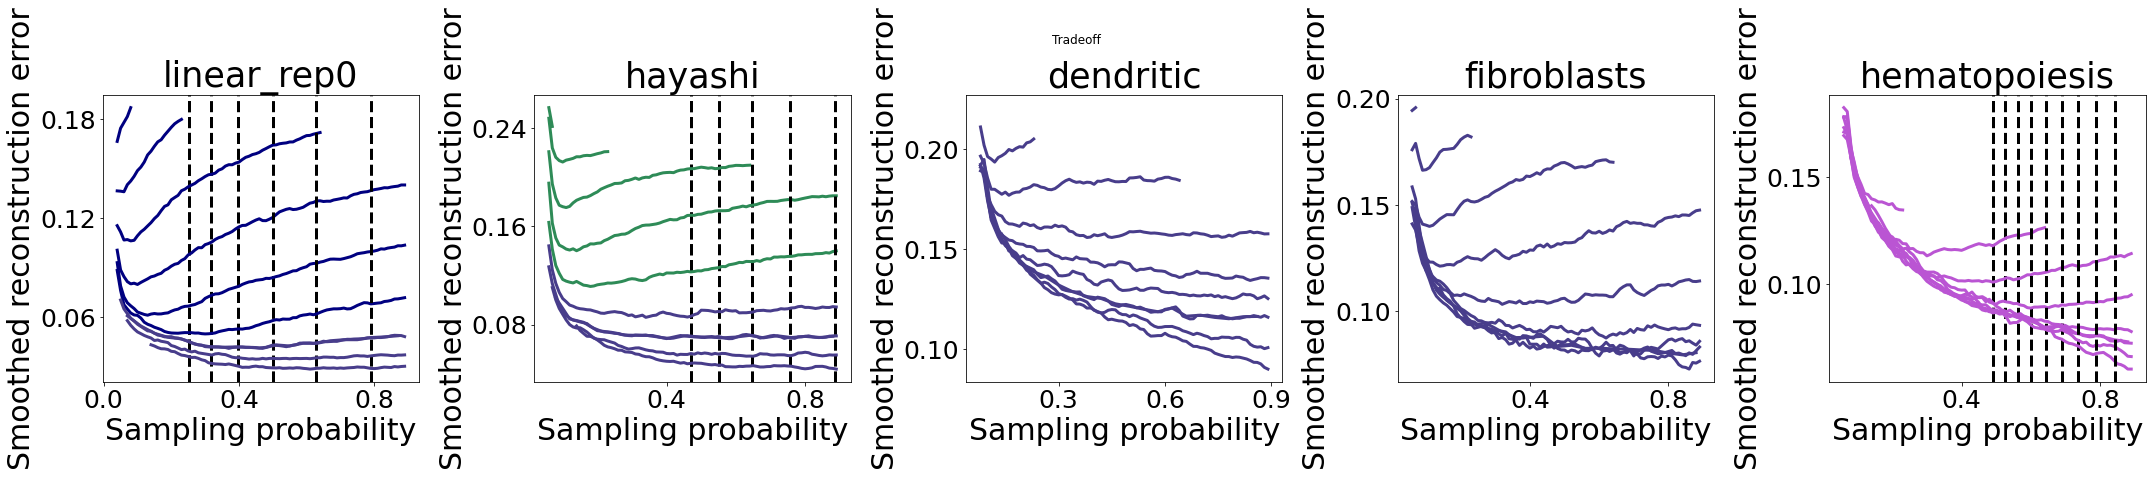

In [27]:
# color differently budgets that demonstrate a tradeoff and those that don't
plot_std = 0
xcol = 'pc'
color_cell_better = 'indianred'
color_read_better = 'darkslateblue'
fig, ax = plt.subplots(**plot_config)
# fig, ax = plt.subplots(2, two_ncols, figsize=(6*two_ncols, 2*6))
# min_seq_locations = 2
# pc_min = 0.00001
# pc_max = 0.99999
for dataset, L_tradeoff in L_tradeoff_dict.items():

    tl = plot_loc[dataset]

    model_read = model_read_dict[dataset]
    model_cell = model_cell_dict[dataset]

    a = model_read.intercept_.take(0)
    b = -model_read.coef_.take(0)
    alpha = model_cell.intercept_.take(0)
    beta = -model_cell.coef_.take(0)

    A = (a - alpha) / b
    C = (beta + b) / b

    print(rf'a: {a}, b: {b}, $\alpha$: {alpha}, $\beta$: {beta}')

    L_grp = L_tradeoff.groupby(['B'])

    # nc = trajs[dataset].ncells
    # # pc_min = 1e-4; pc_max = 1 - pc_min
    # pc_min = 20 / nc; pc_max = 1 - pc_min
    pc_min = L_tradeoff['pc'].min()
    pc_max = L_tradeoff['pc'].max()
    # B_low = np.exp(((beta+b) * np.log(pc_min) + a - alpha) / b)
    B_low = np.exp(A)*pc_min**C
    # B_high = np.exp(((beta+b) * np.log(pc_max) + a - alpha) / b)
    B_high = np.exp(A)*pc_max**C
    
    print(f'Blow: {B_low}, Bhigh: {B_high}')

    for B, sL in L_grp:
        # vals = check_increase_decrease(sL['pc'], sL['l1'], min_seq_locations=min_seq_locations)
        
        # better_et = (sL['pred cell l1'] > sL['pred read l1']).all()
        # better_ec = (sL['pred read l1'] > sL['pred cell l1']).all()
        better_et = B > B_high
        better_ec = B < B_low

        # T.pl.plot_tradeoff_experiments(L_tradeoff=sL, plot_std=plot_std, plot_pc_opt=False, sharey=False, plot_pcs=False, xcol=xcol, ycol='pred cell l1', color='red', axs=ax[tl])
        # T.pl.plot_tradeoff_experiments(L_tradeoff=sL, plot_std=plot_std, plot_pc_opt=False, sharey=False, plot_pcs=False, xcol=xcol, ycol='pred read l1', color='lime', axs=ax[tl])
        
        if better_ec:
            T.pl.plot_tradeoff_experiments(L_tradeoff=sL, plot_std=plot_std, plot_pc_opt=False, sharey=False, plot_pcs=False, xcol=xcol, color=color_cell_better, axs=ax[tl])
        elif better_et:
            T.pl.plot_tradeoff_experiments(L_tradeoff=sL, plot_std=plot_std, plot_pc_opt=False, sharey=False, plot_pcs=False, xcol=xcol, color=color_read_better, axs=ax[tl])
        else:
            T.pl.plot_tradeoff_experiments(L_tradeoff=sL, plot_std=plot_std, plot_pc_opt=False, sharey=False, plot_pcs=False, xcol=xcol, colors=colors, axs=ax[tl])
            
            A = -(a-alpha)/(beta+b)
            C = b / (beta+b)
            pc_min_pred = np.exp(A)*np.power(B, C)
            ax[tl].axvline(x=pc_min_pred, color='black', linewidth=3, linestyle='--')
# L_grp = L_tradeoff.groupby(['B'])

# for B, sL in L_grp:
#     vals = check_increase_decrease(sL['pc'], sL['l1'], min_seq_locations=min_seq_locations)

#     is_decreasing = 'decreasing' in vals
#     is_increasing = 'increasing' in vals
#     if is_increasing and not is_decreasing:
#         T.pl.plot_tradeoff_experiments(L_tradeoff=sL, plot_std=plot_std, plot_pc_opt=False, sharey=False, plot_pcs=False, xcol=xcol, color=color_cell_better, axs=ax[tl])
#     elif not is_increasing and is_decreasing:
#         T.pl.plot_tradeoff_experiments(L_tradeoff=sL, plot_std=plot_std, plot_pc_opt=False, sharey=False, plot_pcs=False, xcol=xcol, color=color_read_better, axs=ax[tl])
#     elif is_increasing and is_decreasing:
#         T.pl.plot_tradeoff_experiments(L_tradeoff=sL, plot_std=plot_std, plot_pc_opt=False, sharey=False, plot_pcs=False, xcol=xcol, colors=colors, axs=ax[tl])
#     else:
#         print('Neither')

plt.suptitle('Tradeoff')
plt.tight_layout()

In [28]:
def compute_emp_min(L_tradeoff):
    L_by_B = L_tradeoff.groupby(L_tradeoff['B'].apply(lambda x: round(x, 6)))#.mean()
    emp_min = []
    for B, sL_by_B in L_by_B:
        sL_by_B_pc = sL_by_B.groupby('pc')['l1'].mean().reset_index()
        idxmin = sL_by_B_pc['l1'].idxmin()
        pc = sL_by_B_pc.loc[idxmin, 'pc']
        l1 = sL_by_B_pc.loc[idxmin, 'l1']
        emp_min.append({'B':B, 'pc':pc, 'l1':l1})
        
    emp_min = pd.DataFrame(emp_min)
    return emp_min

def compute_pred_cell_greater(L_tradeoff):
    df = L_tradeoff.groupby(['B','pc']).mean().reset_index()
    predcol = 'Greater cell error predicted'
    df[predcol] = (df['pred cell l1'] > df['pred read l1']).astype(int)
    # df[predcol] = np.log(df['pred cell l1'] / df['pred read l1'])
    result = df.pivot(columns='pc', index='B', values=predcol)
    return result

a: 0.02125218927053224, b: -0.003322405954729305, $\alpha$: 0.0068982996229861315, $\beta$: -0.011527132262852558
Blow: 7.509186011443512e-09, Bhigh: 0.007897734589113114
a: 0.03360580121235073, b: -0.004300712246646764, $\alpha$: 0.009475835630484028, $\beta$: -0.023593309607264593
Blow: 4.3502084986330117e-11, Bhigh: 0.0017181311684143258
a: 0.09025979181752775, b: -0.0018756221528218628, $\alpha$: 0.03735712167182531, $\beta$: -0.04458663752790089
Blow: 3.7868467453882894e-40, Bhigh: 3.139481602395559e-14
a: 0.06718327422688335, b: -0.0020431302423166114, $\alpha$: 0.0458767056669067, $\beta$: -0.021765475688798455
Blow: 1.7092151813974196e-19, Bhigh: 7.607592686507689e-06
a: 0.04840231996107462, b: -0.0020097648430396397, $\alpha$: 0.048898975143530435, $\beta$: -0.02832082403938909
Blow: 4.65219034526591e-19, Bhigh: 0.2205651943079284


Text(0.02, 0.5, '$p_c$')

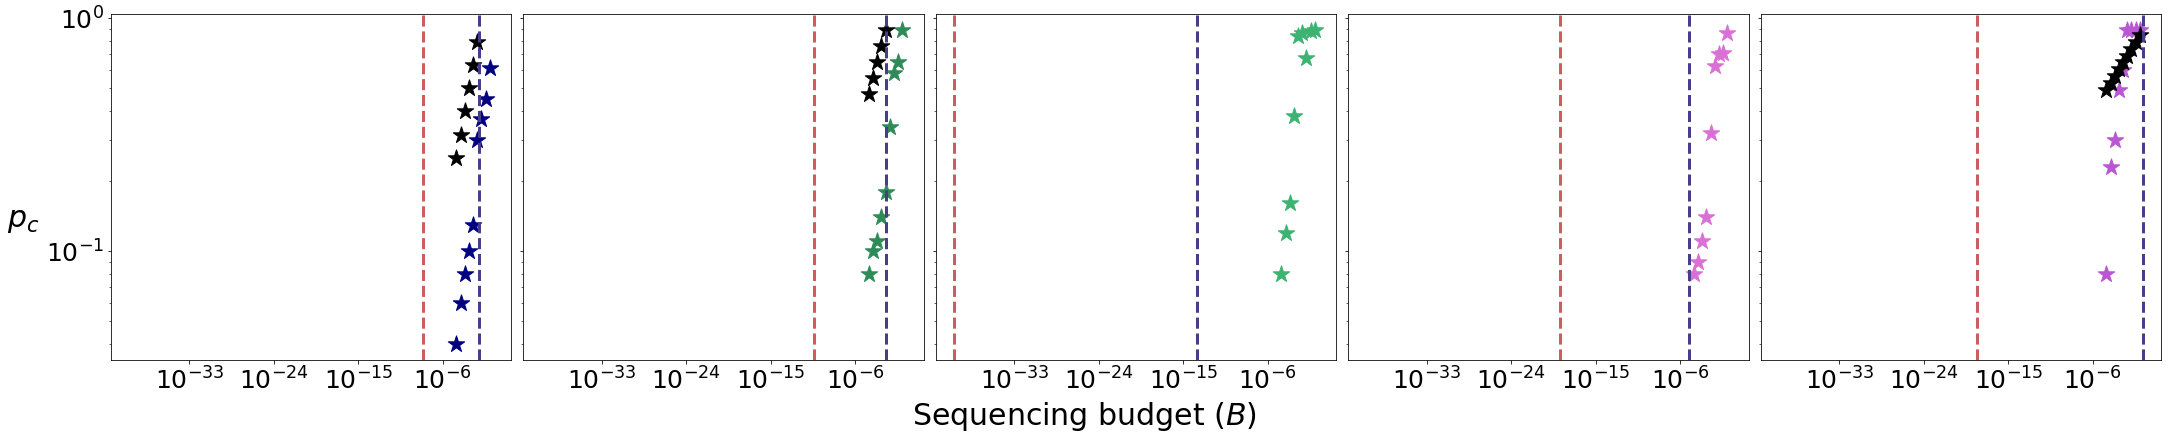

In [29]:
# color differently budgets that demonstrate a tradeoff and those that don't
plot_std = 0
xcol = 'pc'
color_cell_better = 'indianred'
color_read_better = 'darkslateblue'
fig, ax = plt.subplots(**plot_config, sharex=True, sharey=True)
# fig, ax = plt.subplots(2, two_ncols, figsize=(6*two_ncols, 2*6))
# min_seq_locations = 2
# pc_min = 0.00001
# pc_max = 0.99999
ticksize = 25
for dataset, L_tradeoff in L_tradeoff_dict.items():

    tl = plot_loc[dataset]

    model_read = model_read_dict[dataset]
    model_cell = model_cell_dict[dataset]

    a = model_read.intercept_.take(0)
    b = -model_read.coef_.take(0)
    alpha = model_cell.intercept_.take(0)
    beta = -model_cell.coef_.take(0)

    A = (a - alpha) / b
    C = (beta+b) / b

    print(rf'a: {a}, b: {b}, $\alpha$: {alpha}, $\beta$: {beta}')

    L_grp = L_tradeoff.groupby(L_tradeoff['B'].apply(lambda x: round(x, 6)))

    # nc = trajs[dataset].ncells
    # # pc_min = 1e-4; pc_max = 1 - pc_min
    # pc_min = 20 / nc; pc_max = 1 - pc_min
    pc_min = L_tradeoff['pc'].min()
    pc_max = L_tradeoff['pc'].max()

    # df = pd.DataFrame({'B': L_tradeoff['B'].unique(), 'pc_min': pc_min, 'pc_max': pc_max})
    # df['pt_min'] = df['B'] / df['pc_min']
    # df['pt_max'] = df['B'] / df['pc_max']

    # df['pred_cell_err_at_pc_min'] = model_cell.predict(np.log(df[['pc_min']]))
    # df['pred_read_err_at_pc_min'] = model_read.predict(np.log(df[['pt_min']]))
    # df['pred_cell_err_at_pc_max'] = model_cell.predict(np.log(df[['pc_max']]))
    # df['pred_read_err_at_pc_max'] = model_read.predict(np.log(df[['pt_max']]))

    # df['to_reads'] = df['pred_read_err_at_pc_min'] > df['pred_cell_err_at_pc_min']
    # df['to_cells'] = df['pred_cell_err_at_pc_max'] > df['pred_read_err_at_pc_max']

    # B_low = np.exp(((beta+b) * np.log(pc_min) + a - alpha) / b)
    B_low = np.exp(A)*pc_min**C
    # B_high = np.exp(((beta+b) * np.log(pc_max) + a - alpha) / b)
    B_high = np.exp(A)*pc_max**C
    
    print(f'Blow: {B_low}, Bhigh: {B_high}')

    # plot limits
    ax[tl].axvline(x=B_low, color=color_cell_better, linewidth=3, linestyle='--')
    ax[tl].axvline(x=B_high, color=color_read_better, linewidth=3, linestyle='--')

    # plot empirical mins
    # plot predicted min
    emp_min = compute_emp_min(L_tradeoff)
    # emp_min['log B'] = np.log(emp_min['B'])
    # pred_cell_greater = compute_pred_cell_greater(L_tradeoff)
    idx_b = (emp_min['B'] > B_low) & (emp_min['B'] < B_high) 
    Bs_inrange = emp_min.loc[idx_b, 'B'].values
    A = -(a-alpha)/(beta+b)
    C = b / (beta+b)
    pc_min_pred = np.exp(A)*np.power(Bs_inrange, C)
            
    ax[tl].scatter(emp_min['B'], emp_min['pc'], color=colors[dataset], s=300, marker='*')
    ax[tl].scatter(Bs_inrange, pc_min_pred, color='black', s=300, marker='*')
    ax[tl].set_xscale('log')
    ax[tl].set_yscale('log')
    ax[tl].tick_params(axis='y', labelsize=ticksize)
    ax[tl].tick_params(axis='x', labelsize=ticksize)
    

labelsize = 30
ylabel = r'$p_c$'
xlabel = r'Sequencing budget ($B$)'
fig.supxlabel(xlabel, fontsize=labelsize)
fig.supylabel(ylabel, fontsize=labelsize, rotation=0)


In [30]:
df = pd.DataFrame({'B': L_tradeoff['B'].unique(), 'pc_min': pc_min, 'pc_max': pc_max})
df['pt_min'] = df['B'] / df['pc_min']
df['pt_max'] = df['B'] / df['pc_max']

df['pred_cell_err_at_pc_min'] = model_cell.predict(np.log(df[['pc_min']]))
df['pred_read_err_at_pc_min'] = model_read.predict(np.log(df[['pt_min']]))
df['pred_cell_err_at_pc_max'] = model_cell.predict(np.log(df[['pc_max']]))
df['pred_read_err_at_pc_max'] = model_read.predict(np.log(df[['pt_max']]))

df['to_reads'] = df['pred_read_err_at_pc_min'] > df['pred_cell_err_at_pc_min']
df['to_cells'] = df['pred_cell_err_at_pc_max'] > df['pred_read_err_at_pc_max']

In [31]:
# from scipy.spatial.distance import cdist

# fig, ax = plt.subplots(2,two_ncols, figsize=(6*two_ncols,2*6))

# for itraj, (traj_desc, L_tradeoff) in enumerate(L_tradeoff_dict.items()):
#     tl = two_loc[traj_desc]
#     emp_min = compute_emp_min(L_tradeoff)
#     pred_cell_greater = compute_pred_cell_greater(L_tradeoff)
#     emp_min['idx B'] = emp_min['B'].apply(lambda x: np.where(pred_cell_greater.index == x)[0][0])
#     emp_min['idx pc'] = emp_min['pc'].apply(lambda x: np.where(pred_cell_greater.columns == x)[0][0])
    
#     sns.heatmap(pred_cell_greater, ax=ax[tl], fmt='.4f')
#     # ax.scatter(emp_min.loc[0,'pc'], emp_min.loc[0,'B'], marker='*', s=100, color='red') 
#     ax[tl].scatter(emp_min.loc[:,'idx pc'] + 0.5, emp_min.loc[:,'idx B'] + 0.5, marker='*', s=100, color='red') 

#     B1 = emp_min.iloc[0]['B']
#     nc1 = emp_min.iloc[0]['pc']
#     B2 = emp_min.iloc[-1]['B']
#     nc2 = emp_min.iloc[-1]['pc']

#     # v = T.opt.infer_optimal_nc(emp_min['B'].values, B1, nc1, B2, nc2, traj_type='complex')
#     # if v is not None:
#     #     v = v.real
#     #     anchors = pred_cell_greater.columns.values
#     #     emp_min['idx pc lambert'] = cdist(v.reshape(-1,1),anchors.reshape(-1,1)).argmin(1) 

#     #     ax[tl].scatter(emp_min.loc[:,'idx pc lambert'] + 0.2, emp_min.loc[:,'idx B'] + 0.5, marker='*', s=100, color='yellow') 


#     model_read = model_read_dict[traj_desc]
#     model_cell = model_cell_dict[traj_desc]
#     a = model_read.intercept_.take(0)
#     b = model_read.coef_.take(0)
#     c = model_cell.intercept_.take(0)
#     d = model_cell.coef_.take(0)
#     A = (a-c)/(d+b)
#     C = b / (d+b)
#     pc_min_pred = np.exp(A)*np.power(emp_min['B'].values,C)

#     anchors = pred_cell_greater.columns.values
#     emp_min['idx pc pred'] = cdist(pc_min_pred.reshape(-1,1), anchors.reshape(-1,1)).argmin(1) 

#     ax[tl].scatter(emp_min.loc[:,'idx pc pred'] + 0.2, emp_min.loc[:,'idx B'] + 0.5, marker='*', s=100, color='pink') 


#     ax[tl].set_title(traj_desc)

# plt.suptitle('Predictions of minimum', fontsize=20)
# plt.tight_layout()

# # background heatmap, prediction where cell error is greater than read error
# # lines which are all black or all bazz are not expecte to have a tradeoff (at least in this regime) 
# # stars show the empirical  minimums

\begin{gather*}
    \hat{\varepsilon} = softmax^s(\varepsilon_t, \varepsilon_c) = \frac{\varepsilon_t e^{s\varepsilon_t} + \varepsilon_c e^{s\varepsilon_c}}{e^{s\varepsilon_t}+e^{s\varepsilon_c}} \\

\frac{\partial \hat{\varepsilon}}{\partial p_c} = \frac{\varepsilon_t e^{s\varepsilon_t} + \varepsilon_c e^{s\varepsilon_c}}{e^{s\varepsilon_t}+e^{s\varepsilon_c}} \\

z = \varepsilon_t
w = \varepsilon_c

f = z e^{sz} + w e^{sw} \\
f' = z' e^{sz} (sz +1) + w' e^{sw}(sw + 1) \\
g = e^{sz}+e^{sw} \\
g' = sz'e^{sz} + sw' e^{sw} \\
\frac{\partial \hat{\varepsilon}}{\partial p_c} = (f'g - g'f) / g^2 \\
= \frac{ \left( z' e^{sz} (sz +1) + w' e^{sw}(sw + 1) \right) \left(e^{sz}+e^{sw}\right) - \left(sz'e^{sz} + sw' e^{sw}\right) \left(z e^{sz} + w e^{sw}\right)}{(e^{sz}+e^{sw})^2} \\
= \frac{ \left( z' e^{sz} (sz +1) + w' e^{sw}(sw + 1) \right) \left(e^{sz}+e^{sw}\right) - \left(sz'e^{sz} + sw' e^{sw}\right) \left(z e^{sz} + w e^{sw}\right)}{(e^{sz}+e^{sw})^2}\\


f'g = \left( z' e^{sz} (sz +1) + w' e^{sw}(sw + 1) \right) \left(e^{sz}+e^{sw}\right) = 
z' e^{2sz} (sz +1) + w' e^{s(w+z)}(sw + 1) + w' e^{2sw}(sw + 1) + z' e^{s(w+z)} (sz +1) \\


g'f = \left(sz'e^{sz} + sw' e^{sw}\right) \left(z e^{sz} + w e^{sw}\right) =\\
sz'ze^{2sz} + sw'w e^{2sw} + swz'e^{s(z+w)} + szw'e^{s(z+w) } \\

f'g - g'f = z' e^{2sz} + w' e^{2sw} + se^{s(w+z)}(  w'(w-z + 1/s) + z' (z-w +1/s) ) \\
g^2 = e^{2sz}+2e^{s(w+z)} +e^{2sw}\\

z = \varepsilon_t = a + b \log(B/p)\\
w = \varepsilon_c = \alpha + \beta \log(p)\\

z' = -b/p\\
w' = \beta/p\\




\end{gather*}

## Pilot experiments

In [32]:
# read L_read
L_read_pilot_dict = {}
model_read_pilot_dict = {}

L_cell_pilot_dict = {}
model_cell_pilot_dict = {}

for dataset in datasets:
    L_read = pd.read_csv(os.path.join(outdir, f'{dataset}_pilot_pt0.1_L_reads.csv'), index_col=0)
    L_read = L_read.drop(L_read[L_read['l1'].isna()].index)
    L_read_pilot_dict[dataset] = L_read
    
    # save fit of reconstruction error
    model_read = linear_model.LinearRegression()
    model_read.fit(L_read[['log pt']], L_read['l1'])
    model_read_pilot_dict[dataset] = model_read

    L_cell = pd.read_csv(os.path.join(outdir, f'{dataset}_pilot_pt0.1_L_cells.csv'), index_col=0)
    L_cell_pilot_dict[dataset] = L_cell
    
    # save fit of reconstruction error
    model_cell = linear_model.LinearRegression()
    model_cell.fit(L_cell[['log pc']], L_cell['l1'])
    model_cell_pilot_dict[dataset] = model_cell


FileNotFoundError: [Errno 2] No such file or directory: '/cs/labs/mornitzan/nomoriel/trajectory_reconstruction_tradeoff/output_new2/linear_rep0_pilot_pt0.1_L_reads.csv'

a: -0.015561129305476984, b: 0.031011637377873966, $\alpha$: 0.01939055598627559, $\beta$: 0.015079858528230431
Blow: 0.0027090655673456224, Bhigh: 0.2724634778955268
a: 0.04050130999435356, b: 0.026785243367062218, $\alpha$: 0.015228749615779719, $\beta$: 0.042266656365377436
Blow: 0.0018191257555562118, Bhigh: 1.9023754112351414
a: 0.00802722755505375, b: 0.02888547284440313, $\alpha$: 0.06405136454288719, $\beta$: 0.04269710442707839
Blow: 0.0002750205952344239, Bhigh: 0.1077097851539444
a: 0.005707772738089173, b: 0.03092192620176934, $\alpha$: 0.058553894120897856, $\beta$: 0.029874866814953247
Blow: 0.0007169007089877234, Bhigh: 0.14397157333896005
a: -0.007499751552794975, b: 0.024947012887160856, $\alpha$: 0.061254766853724954, $\beta$: 0.03603775751993215
Blow: 6.549038089943706e-05, Bhigh: 0.04779198208545364


Text(0.02, 0.5, '$p_c$')

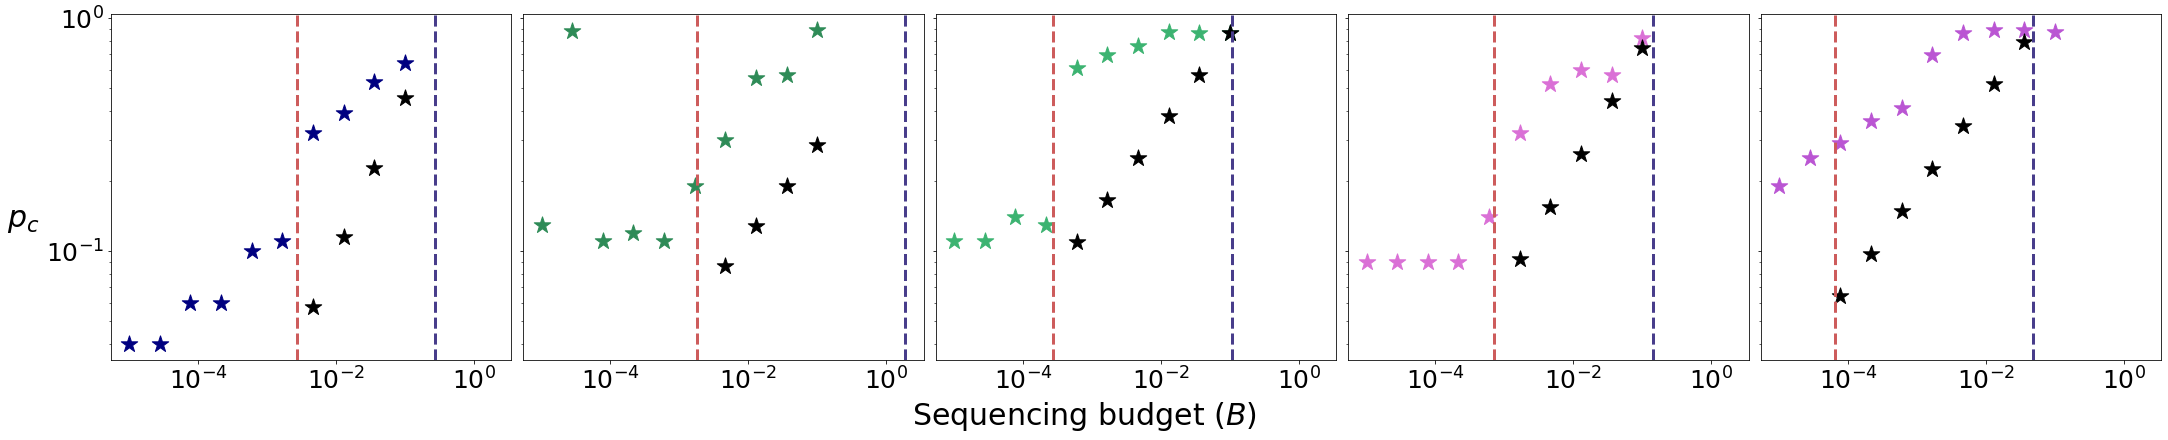

In [ ]:
# color differently budgets that demonstrate a tradeoff and those that don't
plot_std = 0
xcol = 'pc'
color_cell_better = 'indianred'
color_read_better = 'darkslateblue'
fig, ax = plt.subplots(**plot_config, sharex=True, sharey=True)

ticksize = 25
for dataset, L_tradeoff in L_tradeoff_dict.items():

    tl = plot_loc[dataset]

    model_read = model_read_pilot_dict[dataset]
    model_cell = model_cell_pilot_dict[dataset]

    a = model_read.intercept_.take(0)
    b = -model_read.coef_.take(0)
    alpha = model_cell.intercept_.take(0)
    beta = -model_cell.coef_.take(0)

    A = (a - alpha) / b
    C = (beta+b) / b

    print(rf'a: {a}, b: {b}, $\alpha$: {alpha}, $\beta$: {beta}')

    L_grp = L_tradeoff.groupby(L_tradeoff['B'].apply(lambda x: round(x, 6)))

    # nc = trajs[dataset].ncells
    # # pc_min = 1e-4; pc_max = 1 - pc_min
    # pc_min = 20 / nc; pc_max = 1 - pc_min
    pc_min = L_tradeoff['pc'].min()
    pc_max = L_tradeoff['pc'].max()
    # B_low = np.exp(((beta+b) * np.log(pc_min) + a - alpha) / b)
    B_low = np.exp(A)*pc_min**C
    # B_high = np.exp(((beta+b) * np.log(pc_max) + a - alpha) / b)
    B_high = np.exp(A)*pc_max**C
    
    print(f'Blow: {B_low}, Bhigh: {B_high}')

    # plot limits
    ax[tl].axvline(x=B_low, color=color_cell_better, linewidth=3, linestyle='--')
    ax[tl].axvline(x=B_high, color=color_read_better, linewidth=3, linestyle='--')

    # plot empirical mins
    # plot predicted min
    emp_min = compute_emp_min(L_tradeoff)
    # emp_min['log B'] = np.log(emp_min['B'])
    # pred_cell_greater = compute_pred_cell_greater(L_tradeoff)
    idx_b = (emp_min['B'] > B_low) & (emp_min['B'] < B_high) 
    Bs_inrange = emp_min.loc[idx_b, 'B'].values
    A = -(a-alpha)/(beta+b)
    C = b / (beta+b)
    pc_min_pred = np.exp(A)*np.power(Bs_inrange, C)
            
    ax[tl].scatter(emp_min['B'], emp_min['pc'], color=colors[dataset], s=300, marker='*')
    ax[tl].scatter(Bs_inrange, pc_min_pred, color='black', s=300, marker='*')
    ax[tl].set_xscale('log')
    ax[tl].set_yscale('log')
    ax[tl].tick_params(axis='y', labelsize=ticksize)
    ax[tl].tick_params(axis='x', labelsize=ticksize)
    

labelsize = 30
ylabel = r'$p_c$'
xlabel = r'Sequencing budget ($B$)'
fig.supxlabel(xlabel, fontsize=labelsize)
fig.supylabel(ylabel, fontsize=labelsize, rotation=0)
